In [141]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from itertools import combinations
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# функции

# для проверки категориальных признаков


def check_bin_cat(dataframe, column):
    print('Уникальные значения для {a}:{b}'.format(
        a=column, b=dataframe[column].unique()))
    print('='*50)
    print('Количество уникальных значений для {a}:{c}'.format(
        a=column, c=dataframe[column].nunique()))
    print('='*50)
    display('Соотношение в %:',
            dataframe[column].value_counts(normalize=True)*100)
    if dataframe[column].nunique() > 15:
        plt.figure(figsize=(30, 8))
    elif dataframe[column].nunique() in range(8, 16):
        plt.figure(figsize=(12, 7))
    else:
        plt.figure(figsize=(6, 7))
    sns.countplot(dataframe[column])
    plt.title(column)
    plt.show()


# для проверки числовых признаков
def check_nums(data, column, log=False):
    dataframe = data.copy()
    if log == True:
        print('Данные были прологарифмированы!')
        dataframe[column] = dataframe[column].apply(lambda x: np.log(x+1))
    else:
        print('Данные НЕ были прологарифмированы!')
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3-Q1
    plt.figure(figsize=(8, 8))
    sns.displot(dataframe[column])
    plt.title(column)
    plt.show()
    print('для колонки:{}'.format(column), '\nГраницы выбросов:{}'.format(
        [Q1-1.5*IQR, Q3+1.5*IQR]), '\nКоличество выбросов:{}'.format(dataframe[(dataframe[column] < (Q1-1.5*IQR)) | (dataframe[column] > (Q3+1.5*IQR))][column].count()))
    print('Минимальное значение:{a}, Максимальное значение:{b}'.format(
        a=dataframe[column].min(), b=dataframe[column].max()))


# боксплоты
def boxplot(col):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.boxplot(x=col, y='price', data=train[train[col].isin(
        train[col].value_counts().index[:10])], ax=ax)
    ax.set_title('Boxplot для '+col)
    plt.show()

# ttest


def get_stat_dif2(column):
    cols = train.loc[:, column].value_counts().index[:15]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'],
                     train.loc[train.loc[:, column] == comb[1], 'price'], equal_var=False).pvalue \
                <= 0.05/len(combinations_all):  # equal_var=False потому что мы не знаем одинаковая дисперсия или нет
            print('Найдены важные статистические различия для '+column)
            break


# метрика качества
def mape(y_true, y_pred):
    print('MAPE:', np.mean(np.abs((y_pred-y_true) / y_true)) * 100)

In [3]:
test = pd.read_csv('test.csv')
test.info()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [4]:
# ОТДЕЛЬНО выложены парсинг и сборка
train = pd.read_csv('train.csv')
train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63608 entries, 0 to 63607
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           63608 non-null  int64  
 1   bodyType             63605 non-null  object 
 2   brand                63608 non-null  object 
 3   car_url              63608 non-null  object 
 4   color                63608 non-null  object 
 5   description          60813 non-null  object 
 6   engineDisplacement   63480 non-null  float64
 7   enginePower          63605 non-null  float64
 8   equipment_dict       47121 non-null  object 
 9   fuelType             63605 non-null  object 
 10  mileage              63608 non-null  float64
 11  model_name           63608 non-null  object 
 12  numberOfDoors        63608 non-null  object 
 13  parsing_unixtime     63608 non-null  int64  
 14  productionDate       63608 non-null  int64  
 15  vehicleTransmission  63605 non-null 

,Unnamed: 0,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,city
0,0,хэтчбек 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/corolla/...,серебристый,Продам авто в хорошем состоянии. В салоне не к...,1.4,97.0,"['Защита картера', 'Полноразмерное запасное ко...",бензин,...,JAPANESE,3,Информация не учитывается,Оригинал,передний,Левый,Не требует ремонта,Растаможен,380000.0,MSK
1,1,седан,BMW,https://auto.ru/cars/used/sale/bmw/7er/1100876...,зелёный,"Автомобиль в хорошем состоянии , во владении 4...",3.4,211.0,NaN,бензин,...,EUROPEAN,3,Информация не учитывается,Дубликат,задний,Левый,Не требует ремонта,Растаможен,590000.0,MSK
2,2,универсал 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/cla_kl...,чёрный,"Конфета 🔥🖤 авто полностью в броне , фэйс апп 3...",1.3,150.0,"['Круиз-контроль', 'Мультифункциональное рулев...",бензин,...,EUROPEAN,1,Информация не учитывается,Оригинал,передний,Левый,Не требует ремонта,Растаможен,3500000.0,MSK
3,3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,чёрный,"Отличный ухоженный автомобиль, кожанный бежевы...",3.2,238.0,NaN,бензин,...,EUROPEAN,1,Информация не учитывается,Оригинал,полный,Левый,Не требует ремонта,Растаможен,930000.0,MSK
4,4,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,"E200d, 150лс, 9-ст. АКПП, цвет - Черный Обсиди...",2.0,150.0,"['Круиз-контроль', 'Мультифункциональное рулев...",дизель,...,EUROPEAN,1,Информация не учитывается,Оригинал,задний,Левый,Не требует ремонта,Растаможен,2470000.0,MSK


In [5]:
# заполним количество дверей в трейн части. делается сейчас, чтобы не противоречить тесту
door_5 = ['хэтчбек 5 дв.', 'седан', 'универсал 5 дв.',
          'внедорожник 5 дв.', 'лифтбек', 'компактвэн', 'микровэн', 'фаэтон']
door_4 = ['минивэн', 'пикап двойная кабина',
          'седан-хардтоп', 'фургон', 'лимузин', 'хэтчбек 4 дв.']
door_3 = ['хэтчбек 3 дв.', 'внедорожник 3 дв.',
          'внедорожник открытый', 'универсал 3 дв.', 'фастбек']
door_2 = ['купе', 'купе-хардтоп', 'кабриолет', 'родстер', 'пикап полуторная кабина',
          'седан 2 дв.', 'тарга', 'пикап одинарная кабина', 'спидстер']


def fill_doors(row):
    if row['bodyType'] in door_5:
        return 5
    elif row['bodyType'] in door_4:
        return 4
    elif row['bodyType'] in door_3:
        return 3
    elif row['bodyType'] in door_2:
        return 2
    else:
        return 'Not found'


train['numberOfDoors'] = train.apply(lambda row: fill_doors(row), axis=1)

In [6]:
# также удалим колонку Unnamed: 0, это наследие парсинга
train.drop(['Unnamed: 0'], axis=1, inplace=True)

complectation_dict    28268
equipment_dict         9996
Владение              22691
ПТС                       1
dtype: int64

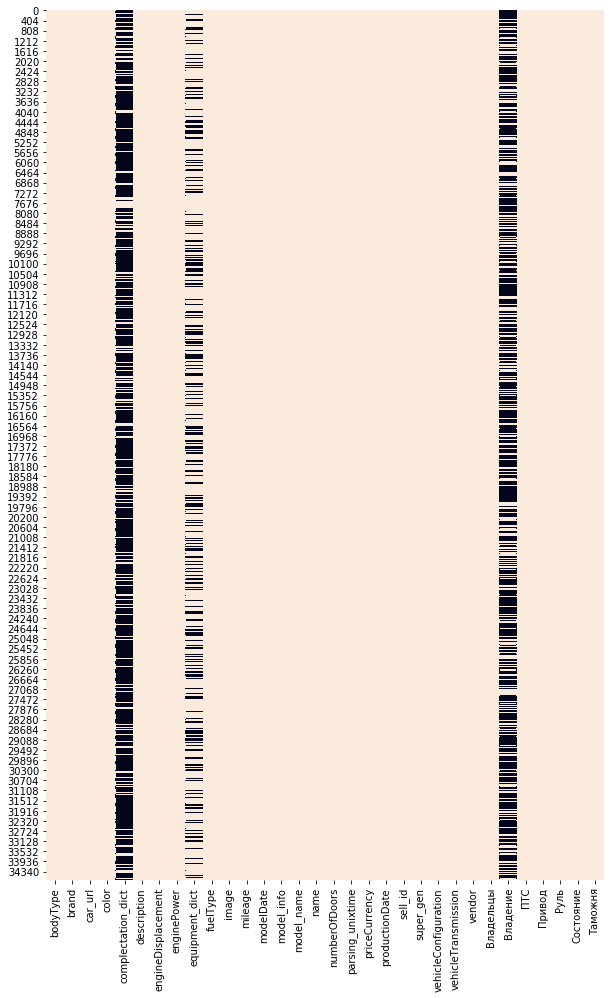

In [7]:
# посмотрим на количество пропусков и их визульное распределение
# тест
display(test.isnull().sum()[test.isnull().sum() > 0])
plt.figure(figsize=(10, 16))
ax = sns.heatmap(test.isnull(), cmap='rocket_r', cbar=False)

как мы видим, пропуски есть в колонках:
- **complectation_dict** (порядка 81,5%) 
- **Владение** (65%)
- **equipment_dict** (28%)
- **ПТС** (всего 1)\
Попробуем взглянуть на колонки детальнее, возможно их можно будет сложить из других колонок или возможно будет проще просто от них избавиться

In [8]:
# начнем с ПТС
display(test['ПТС'].value_counts())
# Так как большая часть оригинал, а пропусков немного, то заполним также
test['ПТС'] = test['ПТС'].fillna('Оригинал')

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [9]:
# посмотрим на Владение
display(test['Владение'].value_counts(), '='*50)
# интересно, что есть и новые и раритетные автомобили, но эту информацию можно взять и из productionDate

# посмотрим нет ли связи между ними и parsing_unixtime
test[test['Владение'].isna() == False][['Владение', 'productionDate',
                                        'parsing_unixtime']].head(15)

1 год и 10 месяцев     209
2 года                 197
1 год                  194
1 год и 1 месяц        193
1 год и 2 месяца       187
                      ... 
19 лет и 7 месяцев       1
31 год и 5 месяцев       1
29 лет и 11 месяцев      1
21 год и 11 месяцев      1
15 лет и 8 месяцев       1
Name: Владение, Length: 275, dtype: int64

'=================================================='

,Владение,productionDate,parsing_unixtime
56,3 года и 2 месяца,2017,1603226490
73,11 месяцев,2019,1603226558
77,4 года и 1 месяц,2016,1603226573
112,2 года и 4 месяца,2018,1603226711
128,1 месяц,2020,1603226771
132,3 года и 10 месяцев,2004,1603226789
135,2 года и 6 месяцев,2017,1603226800
138,6 лет и 4 месяца,2014,1603226811
143,2 месяца,2015,1603226830
144,11 месяцев,2019,1603226834


фактически связи нет, так как данные были спарсены(?) в 2020 году, а есть ряд позиций, где производство например 2015 год, а владение 2 месяца. Возможно это значит, что авто было продано дилеру, поэтому не использовалось, но это инфо в целом можно понять из пробега.\
Как вытащить только Владение для пропусков, ввиду отсутствия связи с productionDate пока тоже не ясно.\
**удалим колонку Владение**

In [10]:
# посмотрим на complectation_dict и equipment_dict
# взглянем на количество значений
display(test['complectation_dict'].dropna().value_counts())
print('='*70)
display(test['equipment_dict'].dropna().value_counts())

# и еще пару строчек, чтобы проверить разнообразные гипотезы:
# test[(test['complectation_dict'].isna()==False)&(test['equipment_dict'].isna()==True)]['complectation_dict'].values
# test[(test['complectation_dict'].isna()==True)&(test['equipment_dict'].isna()==False)]['equipment_dict'].values
# test[test['equipment_dict'].isna()==True][['car_url','equipment_dict']].values
# test[test['complectation_dict'].isna()==True][['car_url','complectation_dict']].head(20).values

{"id":"4562904","name":"Elegance","available_options":["cruise-control","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","alarm","ptf","rain-sensor","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}                                                                                                                                                                                                                                                                                                                                                                                                                                                         

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

**Выводы**
- как показала проверка, для тестовой части нет таких пустых equipment_dict для которых были бы заполнены complectation_dict
- значения complectation_dict по большей части идентичны equipment_dict, просто записаны по другому
- проверка сайта показала, что equipment_dict - это то, что заполняет продавец в своём заявлении
- При этом, если это поле пустое, это не говорит о том, что какой то автомобиль не обладает подушкой безопасности, это говорит скорее о лени продавца, и это также вероятно необходимо подвестить.

**Таким образом**, пару идей:
- complectation_dict удалить.
- для equipment_dict
 - возможно если поле пустое нужно создать отдельную колонку, где это подсветить
 - **пустые колонки заполнить:**
 - сведениями из description (также проверить насколько они соответствуют)
 - возможно это не нужно, так как там будет много данных и при преобразовании мы наплодим кучу колонок
 - вытащить названия модели и комплектации из датафрейма и для пропусков заполнить наиболее распространенными сведениями для данной модели и ее комплектации.
Если позволит время, попробовать

bodyType                   3
description             2795
engineDisplacement       128
enginePower                3
equipment_dict         16487
fuelType                   3
vehicleTransmission        3
Владельцы                 11
ПТС                        4
Привод                     3
Состояние                 11
Таможня                    2
dtype: int64

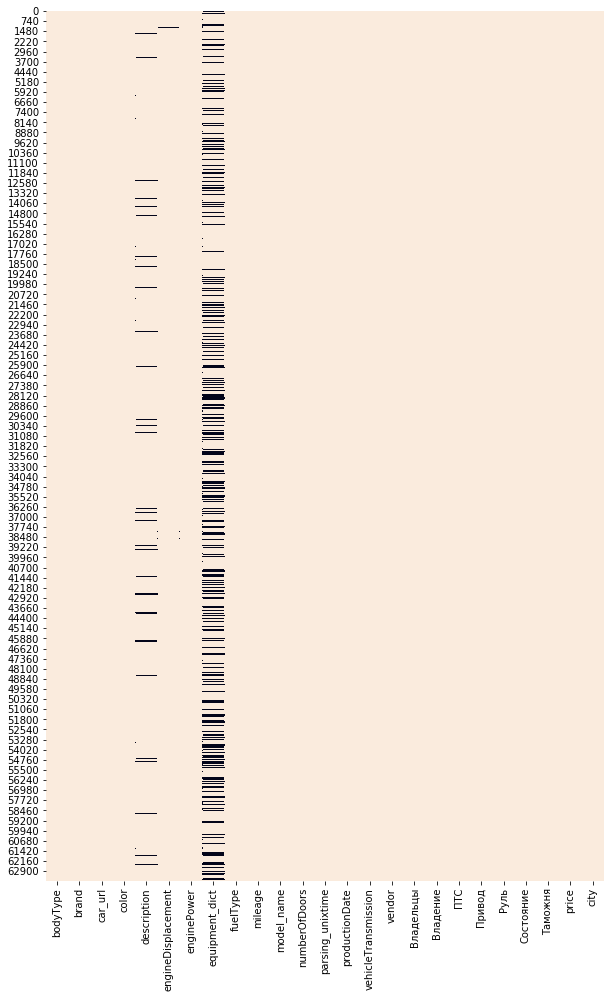

In [11]:
# посмотрим на количество пропусков и их визульное распределение
# трейн
display(train.isnull().sum()[train.isnull().sum() > 0])
plt.figure(figsize=(10, 16))
ax = sns.heatmap(train.isnull(), cmap='rocket_r', cbar=False)

In [12]:
# взглянем на пропуски:
train[train['bodyType'].isna() == True]

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,city
14336,NaN,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tran...,синий,На ходу. Двигатель капитальный.,NaN,NaN,NaN,NaN,150000.0,...,EUROPEAN,3,Информация не учитывается,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,300000.0,MSK
17718,NaN,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,серебристый,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,NaN,NaN,400000.0,...,JAPANESE,3,Информация не учитывается,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,120000.0,MSK
61015,NaN,MOSCVICH,https://auto.ru/cars/used/sale/moscvich/430/10...,серый,Конструкторское бюро СмирноваКоллекционные авт...,NaN,NaN,NaN,NaN,1000.0,...,USSR,3,Информация не учитывается,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,4025000.0,SPB


In [13]:
# там где 3 пропуска это данные было плохо спарсены. всего три позиции ценность не представляют, удалим их
train = train.dropna(subset=['bodyType'], axis=0)

# проверка по "Состояние" показало, что это битые авто. нам такие не нужны. удалим
train = train.dropna(subset=['Состояние'], axis=0)

In [14]:
# проверка по "Владельцы" показала, что это значит, что кол-во владельцев на сайте не указано
# заполним самым частым значением (три и больше)
train['Владельцы'].fillna(3, inplace=True)

# ПТС заполним по аналогии с тестом. есть ощущение, что мы удалим колонку
train['ПТС'].fillna('Оригинал', inplace=True)

# таможню заполнять не будем, эта колонка явно на удаление

# engineDisplacement - как показала проверка это электромобили. у них действительно нет такого параметра. как следствие:

# train[train['engineDisplacement'].isna()==True]['fuelType'].unique()
train['engineDisplacement'].fillna(0, inplace=True)

**Выводы**
- от большей части пропусков мы избавились
- у train те же вопросы с **equipment_dict**
- у части позиций нет description, но это нормальная ситуация, не вижу тут ничего странного

In [15]:
# удалим колонки из тест и трейн, которые мы точно не будем использовать
train.drop(['car_url', 'Владение'], axis=1, inplace=True), test.drop(
    ['car_url', 'image', 'Владение'], axis=1, inplace=True)

(None, None)

## Разделим колонки по типам данным для большего удобства работы и изучения
по тем колонкам, где понятно их содержание (нет списков, словарей и смеси признаков)

In [16]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors',
            'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
num_cols = ['engineDisplacement', 'enginePower', 'mileage']

## Анализ данных
### 1. Признаки где понятно их содержание (нет списков, словарей и смеси признаков)
**1.1 рассмотрим целевую переменную (Price)**

Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

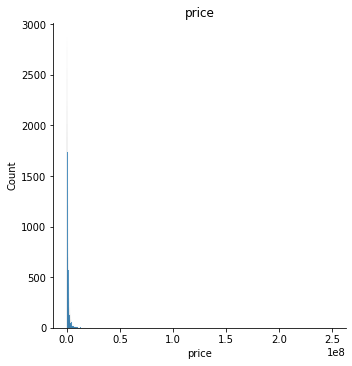

для колонки:price 
Границы выбросов:[-1080000.0, 2680000.0] 
Количество выбросов:5062
Минимальное значение:20000.0, Максимальное значение:250031648.0
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

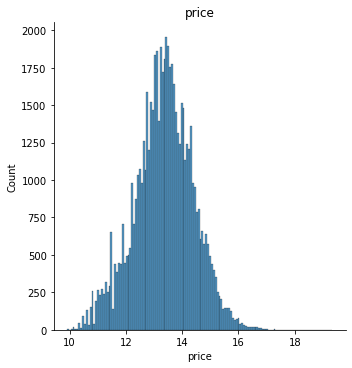

для колонки:price 
Границы выбросов:[10.685335040598698, 16.076044168978445] 
Количество выбросов:658
Минимальное значение:9.90353755128617, Максимальное значение:19.337098063813922


(None, None)

In [17]:
check_nums(train, 'price'), check_nums(train, 'price', log=True)

In [18]:
# есть значение 250031648.0! посмотрим что это+посмотрим какие значения соответствуют выбросам
# по размышлениям логично, что авто может стоит больше 3 млн, поэтому пока будем считать за выбросы данные больше 20 млн
display(train[train.price == 250031648.0])
print('='*140)
display(train[train.price > 20000000])

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_name,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,city
42468,купе,FERRARI,красный,Прикоснитесь к прекрасному! Эксклюзивный спорт...,6.3,963.0,NaN,гибрид,500.0,LAFERRARI,...,роботизированная,EUROPEAN,1,Оригинал,задний,Левый,Не требует ремонта,Растаможен,250031648.0,MSK


,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_name,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,city
3716,седан,MERCEDES,чёрный,Оригинальный Mercedes-Benz 300b Cabriolet 1953...,3.0,115.0,['Кожа (Материал салона)'],бензин,1000.0,W186,...,механическая,EUROPEAN,1,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22885650.0,MSK
5043,внедорожник 5 дв.,MERCEDES,чёрный,G63 в состоянии нового! Машина почти не ездила...,4.0,585.0,"['Подушки безопасности боковые задние', 'Подуш...",бензин,2300.0,G_KLASSE_AMG,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,20500000.0,MSK
5705,купе,MERCEDES,серый,"Кузов выполнен полностью из карбона, единствен...",5.4,626.0,"['Круиз-контроль', 'Электростеклоподъёмники пе...",бензин,15000.0,SLR_KLASSE,...,автоматическая,EUROPEAN,3,Оригинал,задний,Левый,Не требует ремонта,Растаможен,23900000.0,MSK
9660,минивэн,MERCEDES,чёрный,Максимально возможная комплектация с ювелиркой...,2.1,190.0,"['Антипробуксовочная система (ASR)', 'Система ...",дизель,47.0,V_KLASSE,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,27000000.0,MSK
15463,внедорожник 5 дв.,MERCEDES,чёрный,Компания BRABUS совместно с мировым тюнинг-ате...,4.0,585.0,"['Круиз-контроль', 'Мультифункциональное рулев...",бензин,5.0,G_KLASSE_AMG,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,28900000.0,MSK
15563,родстер,MERCEDES,красный,MERCEDES-BENZ SLS AMG GT ROADSTER FINAL EDITIO...,6.2,591.0,"['Круиз-контроль', 'Мультифункциональное рулев...",бензин,4800.0,SLS_AMG,...,роботизированная,EUROPEAN,3,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22500000.0,MSK
16111,внедорожник 5 дв.,MERCEDES,чёрный,В продаже новый гелендваген в оригинальном мат...,4.0,422.0,NaN,бензин,5000.0,G_KLASSE,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,25000000.0,MSK
17173,минивэн,MERCEDES,чёрный,Mercedes-Benz V-class ZART 97 LemanАвтомобиль ...,2.1,190.0,"['Тонированные стекла', 'Передний центральный ...",дизель,1.0,V_KLASSE,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,24900000.0,MSK
19540,внедорожник 5 дв.,MERCEDES,чёрный,Полнейшая комплектация автомобиля!Есть другие ...,4.0,558.0,"['Круиз-контроль', 'Мультифункциональное рулев...",бензин,10.0,MAYBACH_GLS,...,автоматическая,EUROPEAN,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен,23250000.0,MSK
22255,купе,MERCEDES,чёрный,"Автомобиль отреставрирован в Kienle, состояние...",3.0,150.0,NaN,бензин,12000.0,W188,...,механическая,EUROPEAN,3,Оригинал,задний,Левый,Не требует ремонта,Растаможен,52500000.0,MSK


Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

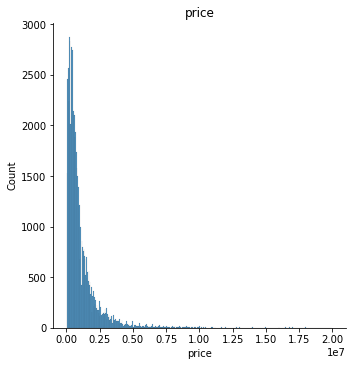

для колонки:price 
Границы выбросов:[-1080000.0, 2680000.0] 
Количество выбросов:5029
Минимальное значение:20000.0, Максимальное значение:19999900.0
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

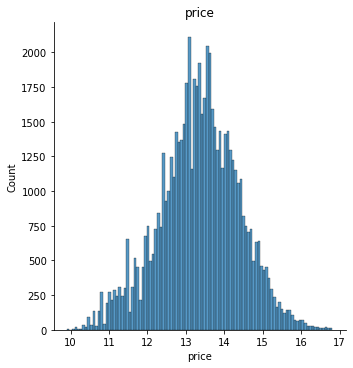

для колонки:price 
Границы выбросов:[10.685335040598698, 16.076044168978445] 
Количество выбросов:625
Минимальное значение:9.90353755128617, Максимальное значение:16.811237881506013


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


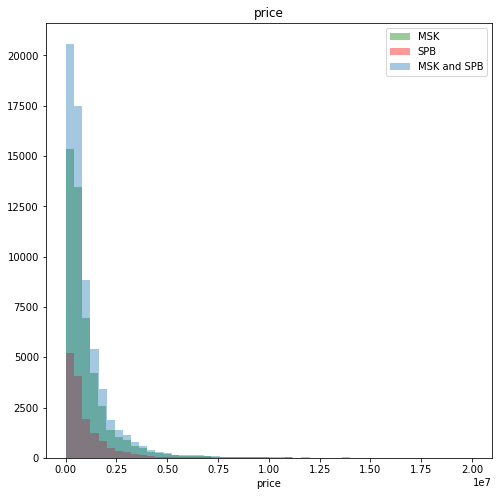

In [19]:
# избавимся от выбросов и снова посмотрим на распределения, в т.ч. по городам
train = train[train.price < 20000000]
check_nums(train, 'price'), check_nums(train, 'price', log=True)

plt.figure(figsize=(8, 8))
sns.distplot(train[train['city'] == 'MSK']['price'],
             kde=False, color="g", label='MSK')
sns.distplot(train[train['city'] == 'SPB']['price'],
             kde=False, color="r", label='SPB')
sns.distplot(train['price'], kde=False, label='MSK and SPB')
plt.title('price')
plt.legend()
plt.show()

**Выводы**
- кажется в данных присутствуют выбросы. Пока за выбросы отмечено все что **свыше 20 млн**, однако данный вопросы может быть пересмотрен.
- тенденции в Москве и СПБ по цене в целом совпадают, Так что идея взять данные из СПб по всей видимости была неплохой
- данные выглядят более нормальными после **логарифмирования**. возможно для модели это будем полезно

**2. рассмотрим категориальные переменные**

In [20]:
# отдельно рассмотрим sell_id и priceCurrency
display(test['sell_id'].value_counts())
display(test['priceCurrency'].value_counts())

1101243311    1
1101207839    1
1101219298    1
1101297124    1
1101364709    1
             ..
1099483756    1
1101316717    1
1101210225    1
1101347442    1
1092026368    1
Name: sell_id, Length: 34686, dtype: int64

RUB    34686
Name: priceCurrency, dtype: int64

все sell_id различны\
в то же время вся валюта это только Rub\
Соответственно эти данные не несут каких то полезных данных. их можно удалить

In [21]:
test.drop(['sell_id', 'priceCurrency'], axis=1, inplace=True)

Уникальные значения для bodyType:['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон']
Количество уникальных значений для bodyType:24


'Соотношение в %:'

седан                      37.902900
внедорожник 5 дв.          35.253416
лифтбек                     6.434873
хэтчбек 5 дв.               6.123508
универсал 5 дв.             3.678718
минивэн                     2.868593
купе                        2.375598
компактвэн                  1.409791
хэтчбек 3 дв.               1.398259
пикап двойная кабина        0.807242
купе-хардтоп                0.455515
внедорожник 3 дв.           0.331546
родстер                     0.285418
фургон                      0.279652
кабриолет                   0.259471
седан-хардтоп               0.034596
микровэн                    0.020181
седан 2 дв.                 0.017298
лимузин                     0.017298
пикап полуторная кабина     0.014415
пикап одинарная кабина      0.014415
внедорожник открытый        0.008649
тарга                       0.005766
фастбек                     0.002883
Name: bodyType, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


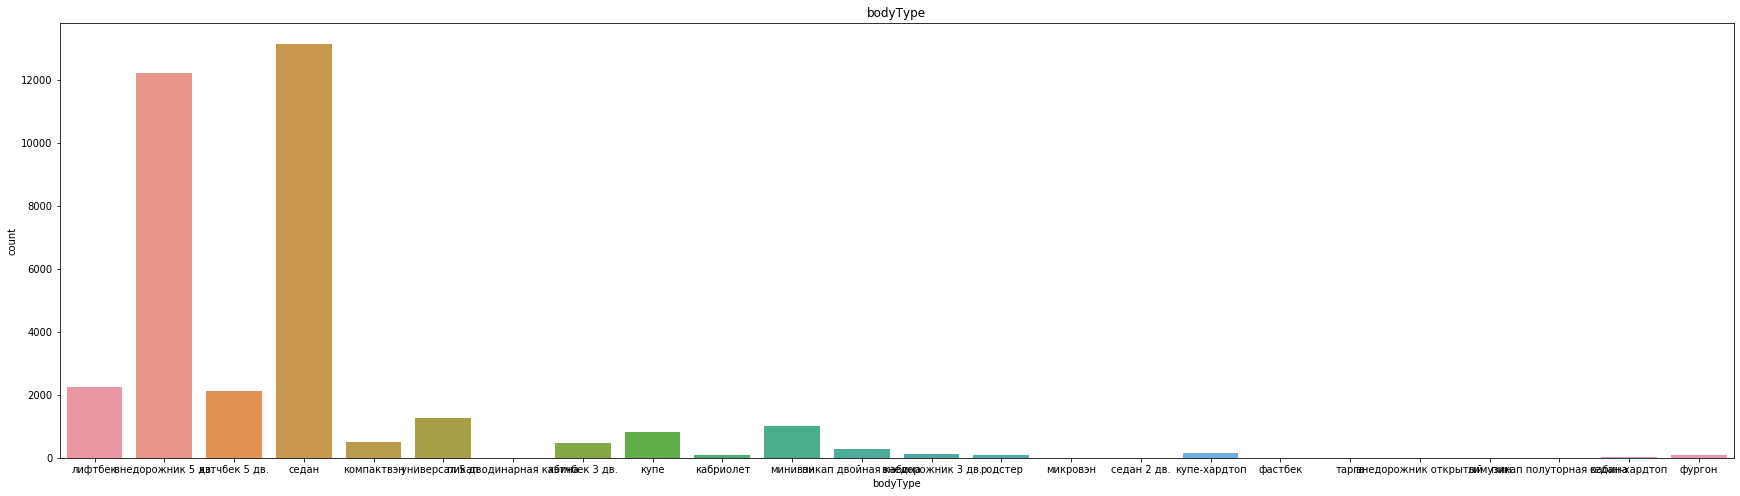

Уникальные значения для brand:['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
Количество уникальных значений для brand:12


'Соотношение в %:'

BMW           12.895693
VOLKSWAGEN    12.696765
NISSAN        12.665052
MERCEDES      12.050972
TOYOTA        11.281209
AUDI           9.862769
MITSUBISHI     8.196390
SKODA          7.902324
VOLVO          4.217840
HONDA          3.315459
INFINITI       2.511100
LEXUS          2.404428
Name: brand, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


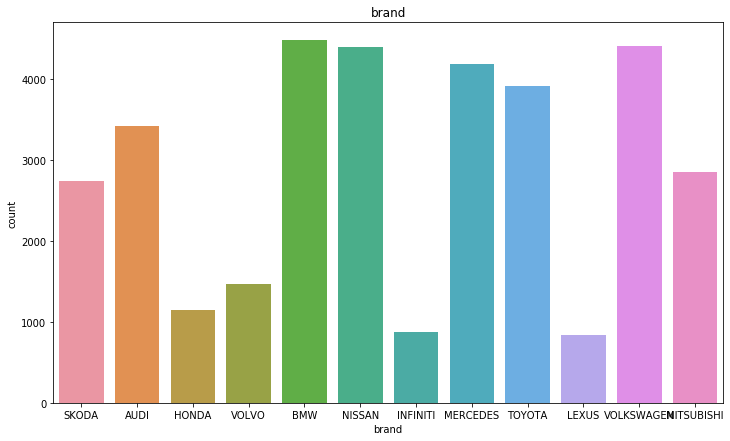

Уникальные значения для color:['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
Количество уникальных значений для color:16


'Соотношение в %:'

чёрный         31.741913
белый          17.681485
серебристый    11.857810
серый          11.485902
синий           9.482212
красный         4.413885
коричневый      4.327394
зелёный         2.744623
бежевый         1.842242
голубой         1.317534
золотистый      0.766880
пурпурный       0.732284
фиолетовый      0.631379
жёлтый          0.559303
оранжевый       0.377674
розовый         0.037479
Name: color, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


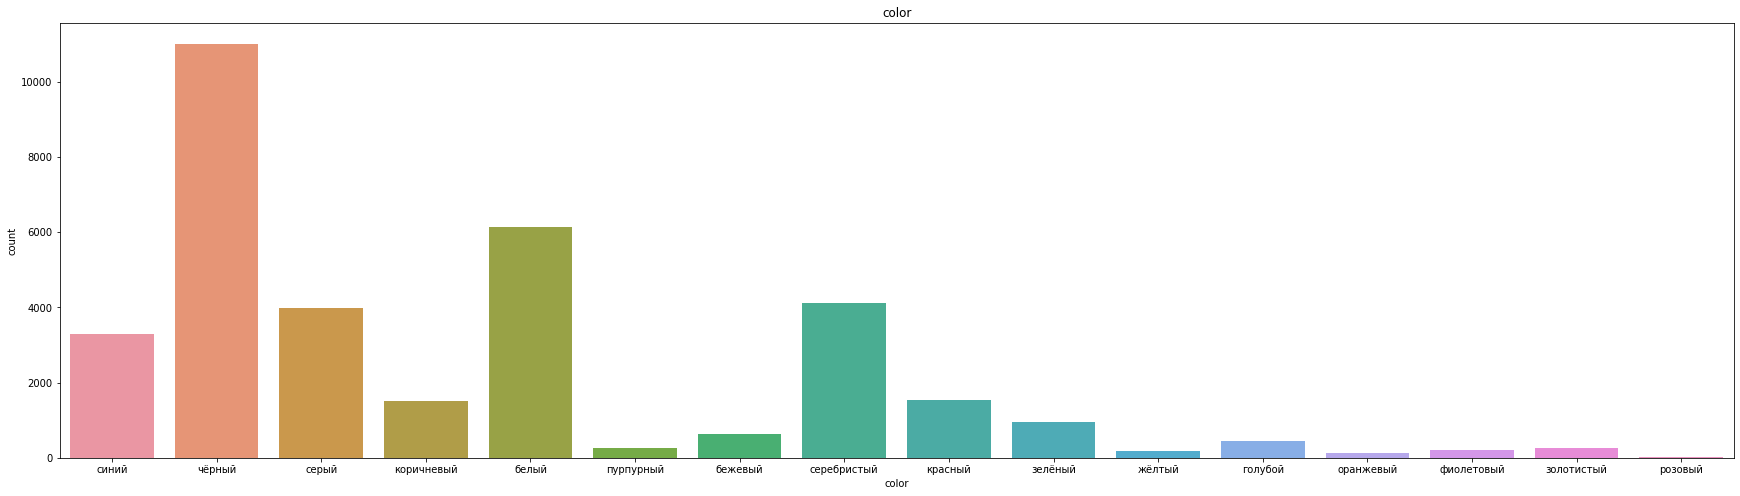

Уникальные значения для fuelType:['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Количество уникальных значений для fuelType:5


'Соотношение в %:'

бензин     82.456899
дизель     16.721444
гибрид      0.642911
электро     0.158565
газ         0.020181
Name: fuelType, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


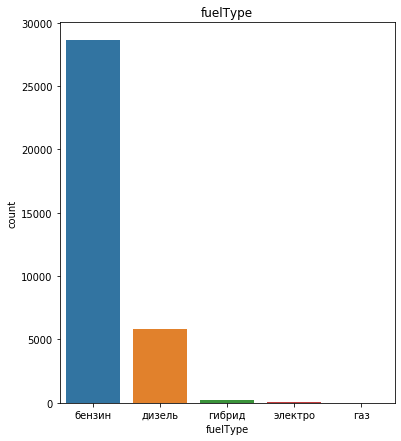

Уникальные значения для model_name:['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_WGN'
 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER' 'SABER' 'MOBILIO' 'CROSSROAD'
 'INSIGHT' 'TORNEO' 'AIRWAVE' 'DOMANI' 'RAFAGA' 'CITY' 'VIGOR' 'ORTHIA'
 'PARTNER' 'V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90'
 'V90_CROSS_COUNTRY' 'S60' 'XC70' 'V40_CC' 'S40' 'S90' 'V40' '240

'Соотношение в %:'

OCTAVIA            4.088105
5ER                2.957966
LANCER             2.464971
E_KLASSE           2.332353
PASSAT             2.254512
                     ...   
RS4                0.002883
920                0.002883
MASTER_ACE_SURF    0.002883
NADIA              0.002883
LAFESTA            0.002883
Name: model_name, Length: 544, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


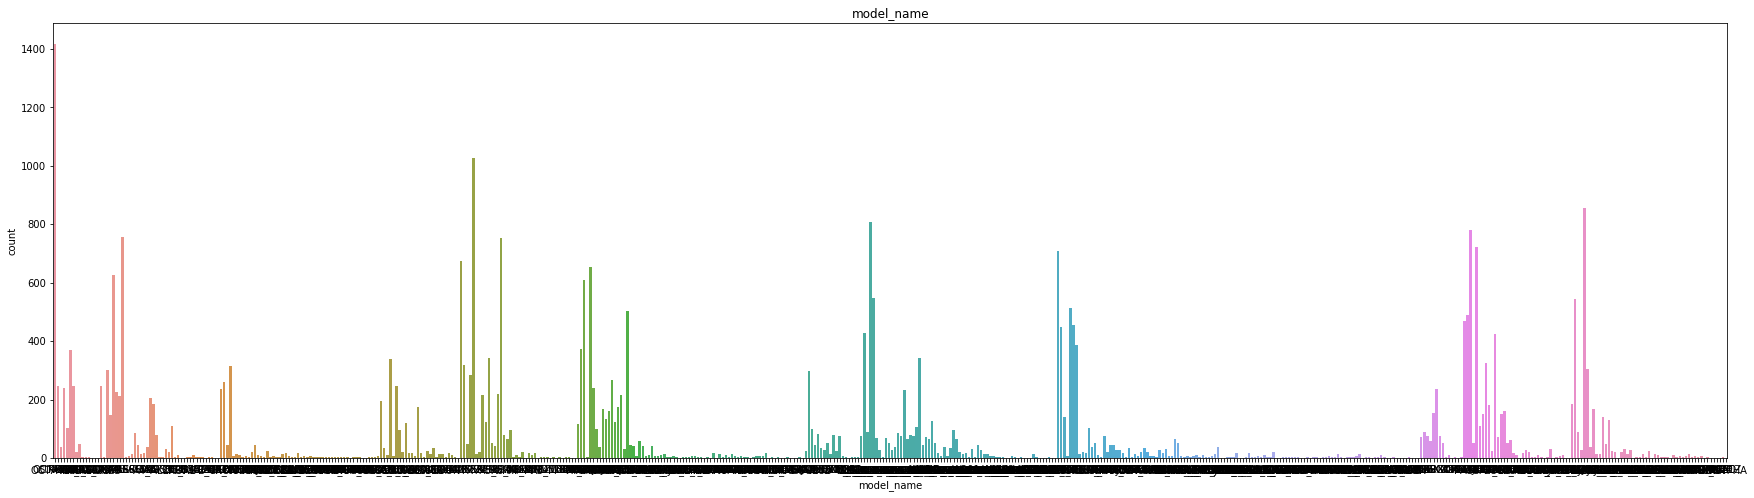

Уникальные значения для numberOfDoors:[5 4 2 3 0]
Количество уникальных значений для numberOfDoors:5


'Соотношение в %:'

5    53.920890
4    40.725365
2     3.476907
3     1.873955
0     0.002883
Name: numberOfDoors, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


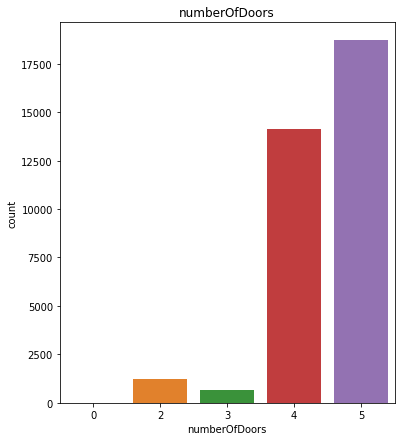

Уникальные значения для vehicleTransmission:['роботизированная' 'механическая' 'автоматическая' 'вариатор']
Количество уникальных значений для vehicleTransmission:4


'Соотношение в %:'

автоматическая      56.495416
механическая        20.783601
вариатор            11.529147
роботизированная    11.191835
Name: vehicleTransmission, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


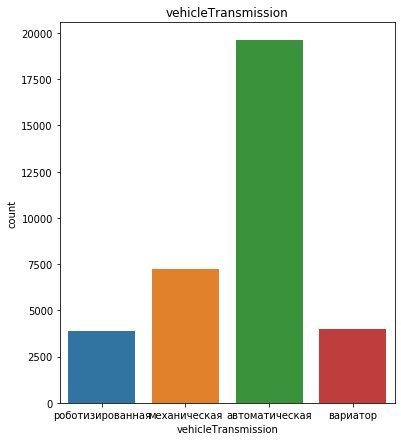

Уникальные значения для vendor:['EUROPEAN' 'JAPANESE']
Количество уникальных значений для vendor:2


'Соотношение в %:'

EUROPEAN    59.626362
JAPANESE    40.373638
Name: vendor, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


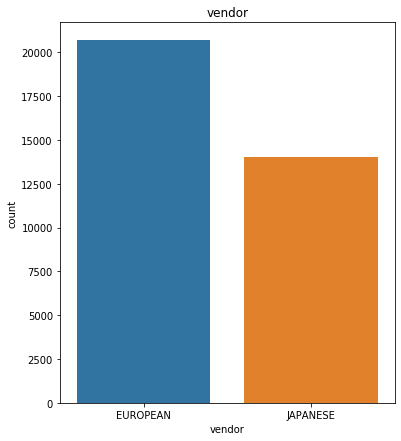

Уникальные значения для Владельцы:['3 или более' '1\xa0владелец' '2\xa0владельца']
Количество уникальных значений для Владельцы:3


'Соотношение в %:'

3 или более    46.004152
1 владелец     27.270368
2 владельца    26.725480
Name: Владельцы, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


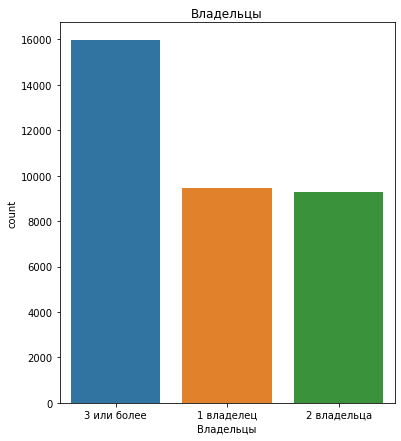

Уникальные значения для ПТС:['Оригинал' 'Дубликат']
Количество уникальных значений для ПТС:2


'Соотношение в %:'

Оригинал    86.775644
Дубликат    13.224356
Name: ПТС, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


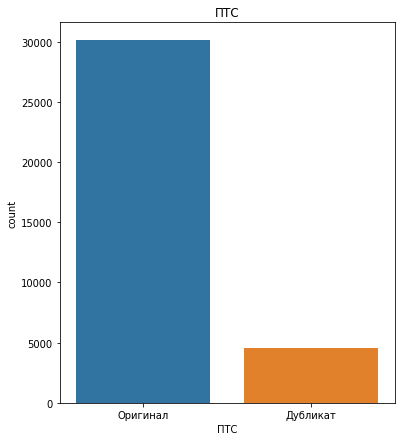

Уникальные значения для Привод:['передний' 'полный' 'задний']
Количество уникальных значений для Привод:3


'Соотношение в %:'

передний    44.874013
полный      43.302773
задний      11.823214
Name: Привод, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


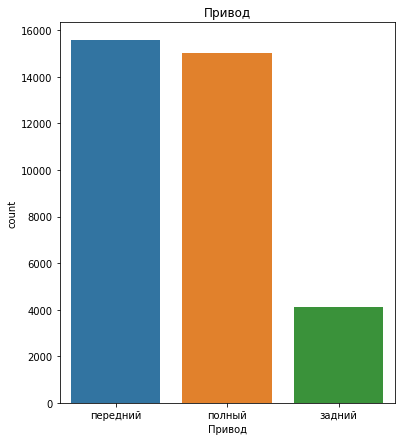

Уникальные значения для Руль:['Левый' 'Правый']
Количество уникальных значений для Руль:2


'Соотношение в %:'

Левый     95.966672
Правый     4.033328
Name: Руль, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


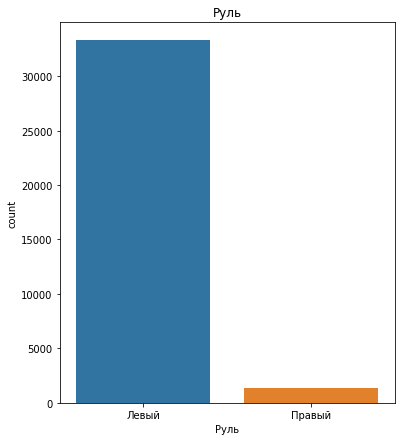

Уникальные значения для Состояние:['Не требует ремонта']
Количество уникальных значений для Состояние:1


'Соотношение в %:'

Не требует ремонта    100.0
Name: Состояние, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


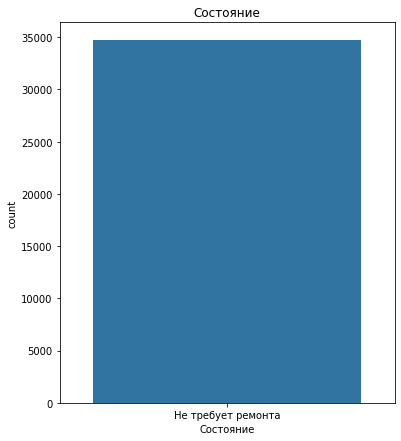

Уникальные значения для Таможня:['Растаможен']
Количество уникальных значений для Таможня:1


'Соотношение в %:'

Растаможен    100.0
Name: Таможня, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


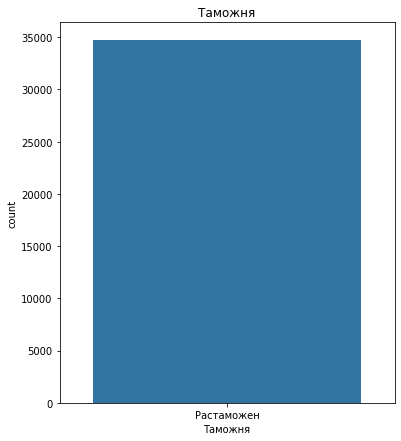

In [22]:
# Рассмотрим оставщиеся категориальные признаки для тестовой части
for col in cat_cols:
    check_bin_cat(test, col)

Уникальные значения для bodyType:['хэтчбек 5 дв.' 'седан' 'универсал 5 дв.' 'внедорожник 5 дв.' 'лифтбек'
 'хэтчбек 3 дв.' 'купе' 'компактвэн' 'купе-хардтоп' 'минивэн' 'кабриолет'
 'пикап двойная кабина' 'внедорожник 3 дв.' 'седан-хардтоп' 'родстер'
 'микровэн' 'фургон' 'пикап полуторная кабина' 'лимузин' 'седан 2 дв.'
 'тарга' 'пикап одинарная кабина' 'внедорожник открытый' 'универсал 3 дв.'
 'спидстер' 'фастбек' 'хэтчбек 4 дв.' 'фаэтон']
Количество уникальных значений для bodyType:28


'Соотношение в %:'

седан                      35.273202
внедорожник 5 дв.          31.731722
хэтчбек 5 дв.              11.516496
универсал 5 дв.             5.130505
лифтбек                     3.972562
минивэн                     2.794166
хэтчбек 3 дв.               2.479508
компактвэн                  2.348925
купе                        1.711741
внедорожник 3 дв.           1.173676
пикап двойная кабина        0.541212
фургон                      0.297352
кабриолет                   0.258020
купе-хардтоп                0.256447
родстер                     0.162049
внедорожник открытый        0.135303
фастбек                     0.055065
микровэн                    0.047199
пикап полуторная кабина     0.026746
седан-хардтоп               0.023599
седан 2 дв.                 0.015733
пикап одинарная кабина      0.015733
тарга                       0.009440
хэтчбек 4 дв.               0.009440
лимузин                     0.007866
фаэтон                      0.003147
спидстер                    0.001573
у

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


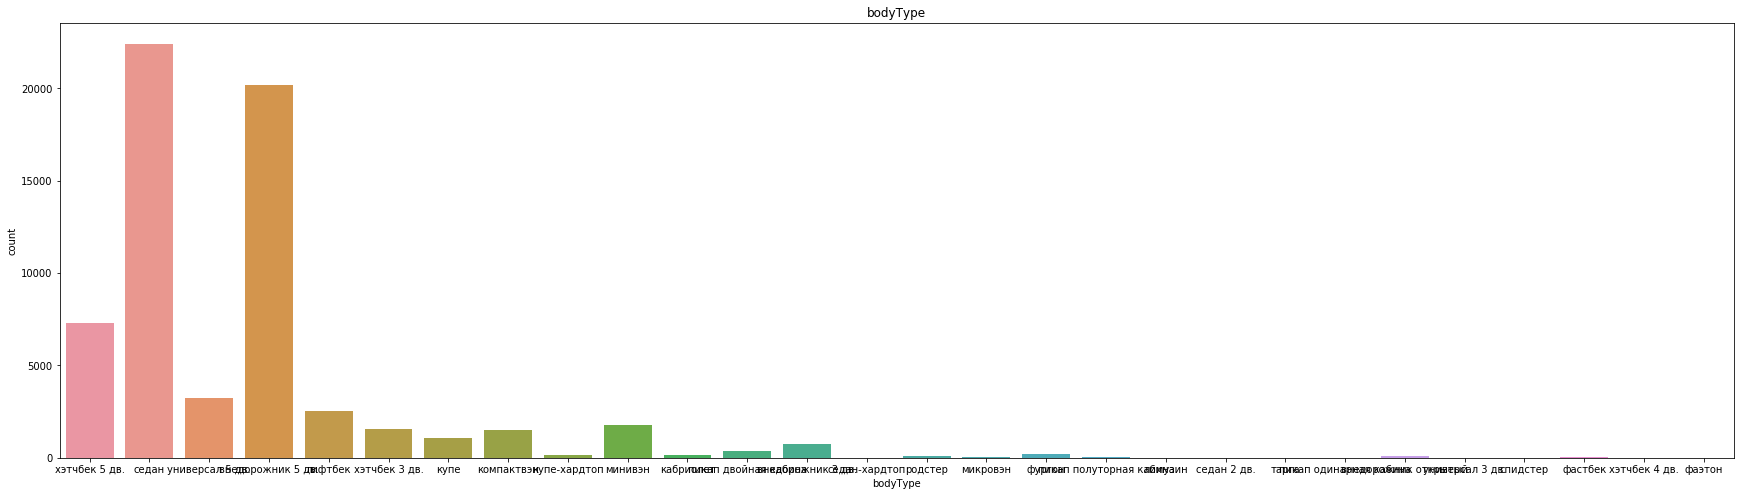

Уникальные значения для brand:['TOYOTA' 'BMW' 'MERCEDES' 'VOLVO' 'SKODA' 'NISSAN' 'LEXUS' 'VOLKSWAGEN'
 'HONDA' 'AUDI' 'MITSUBISHI' 'INFINITI' 'CITROEN' 'LAND_ROVER' 'FORD'
 'VAZ' 'HYUNDAI' 'OPEL' 'GAZ' 'CHERY' 'CHEVROLET' 'DAEWOO' 'KIA' 'MAZDA'
 'CHRYSLER' 'SUBARU' 'GREAT_WALL' 'JEEP' 'RENAULT' 'MINI' 'DODGE' 'ISUZU'
 'BYD' 'LINCOLN' 'PORSCHE' 'SUZUKI' 'UAZ' 'LIFAN' 'JAGUAR' 'SMART'
 'PEUGEOT' 'DATSUN' 'RAVON' 'MOSCVICH' 'HAVAL' 'DAIHATSU' 'PONTIAC'
 'ROVER' 'GEELY' 'GENESIS' 'SEAT' 'CADILLAC' 'LAMBORGHINI' 'FIAT'
 'MASERATI' 'BENTLEY' 'ROLLS_ROYCE' 'ALFA_ROMEO' 'FERRARI' 'VORTEX' 'FAW'
 'DONGFENG' 'ACURA' 'HUMMER' 'GMC' 'BRILLIANCE' 'TESLA' 'CHANGAN' 'DACIA'
 'BUICK' 'DAIMLER']
Количество уникальных значений для brand:71


'Соотношение в %:'

VOLKSWAGEN     7.106559
MERCEDES       6.884725
VAZ            6.791901
BMW            6.596813
KIA            6.175170
                 ...   
DONGFENG       0.022026
BYD            0.022026
LAMBORGHINI    0.009440
DACIA          0.006293
DAIMLER        0.006293
Name: brand, Length: 71, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


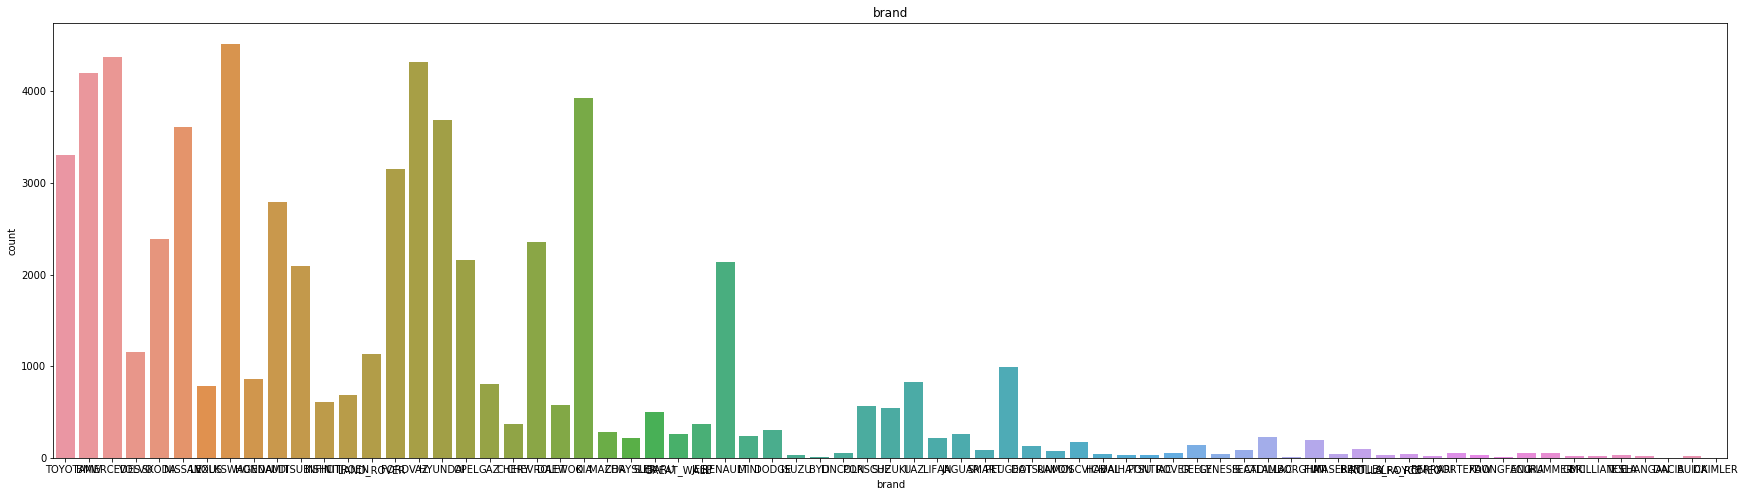

Уникальные значения для color:['серебристый' 'зелёный' 'чёрный' 'белый' 'синий' 'серый' 'бежевый'
 'золотистый' 'красный' 'коричневый' 'голубой' 'жёлтый' 'пурпурный'
 'оранжевый' 'фиолетовый' 'розовый']
Количество уникальных значений для color:16


'Соотношение в %:'

чёрный         25.672976
белый          18.089709
серый          12.199305
серебристый    12.189865
синий           9.604946
красный         5.663850
коричневый      4.408364
зелёный         4.073252
бежевый         2.251381
голубой         1.689715
пурпурный       0.904643
золотистый      0.884190
жёлтый          0.830698
фиолетовый      0.775633
оранжевый       0.723714
розовый         0.037759
Name: color, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


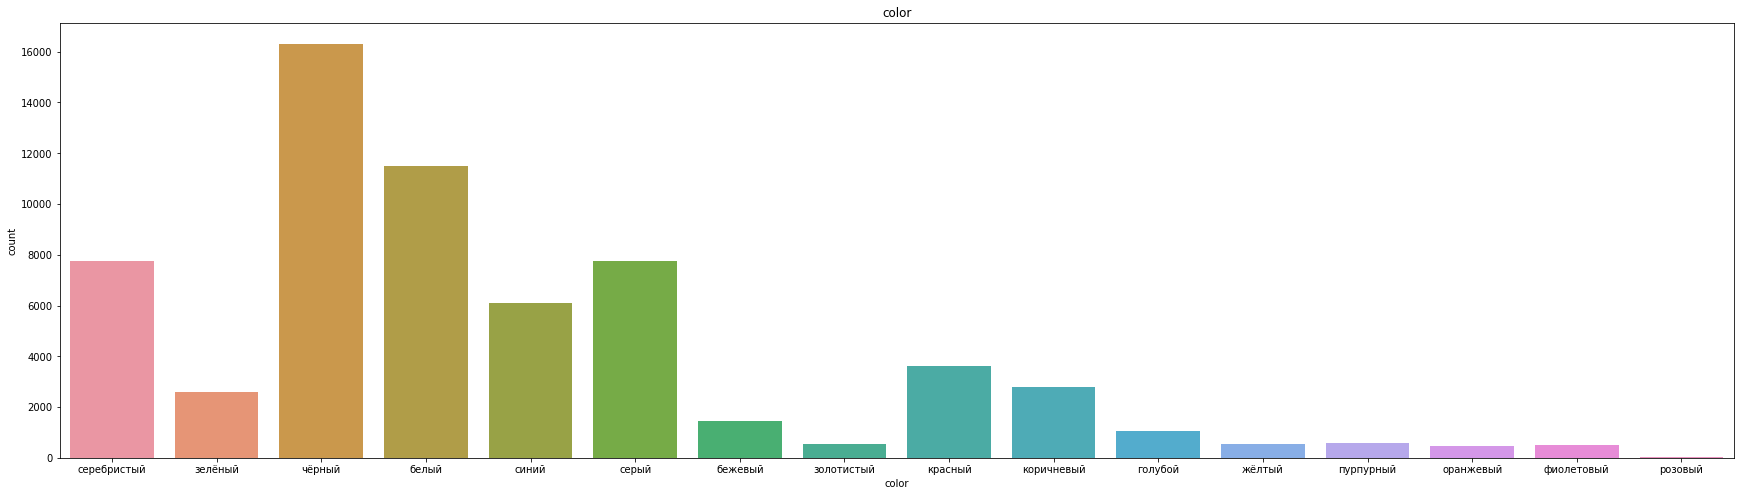

Уникальные значения для fuelType:['бензин' 'дизель' 'гибрид' 'электро' 'газ']
Количество уникальных значений для fuelType:5


'Соотношение в %:'

бензин     85.431318
дизель     14.007017
гибрид      0.335111
электро     0.196661
газ         0.029893
Name: fuelType, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


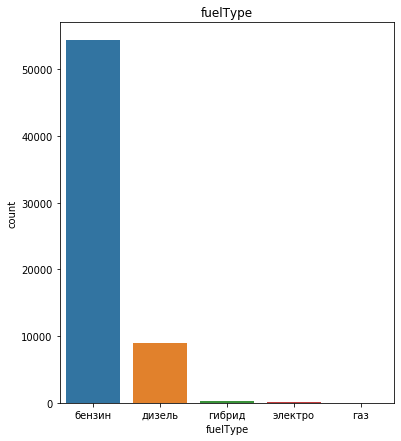

Уникальные значения для model_name:['COROLLA' '7ER' 'CLA_KLASSE' ... 'CAMPO' '504' 'CAPPUCCINO']
Количество уникальных значений для model_name:1297


'Соотношение в %:'

FOCUS         2.297006
OCTAVIA       1.881657
RIO           1.628357
ASTRA         1.554412
SOLARIS       1.524520
                ...   
TL            0.001573
GRAND_PRIX    0.001573
DS_420        0.001573
ALLEX         0.001573
D_MAX         0.001573
Name: model_name, Length: 1297, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


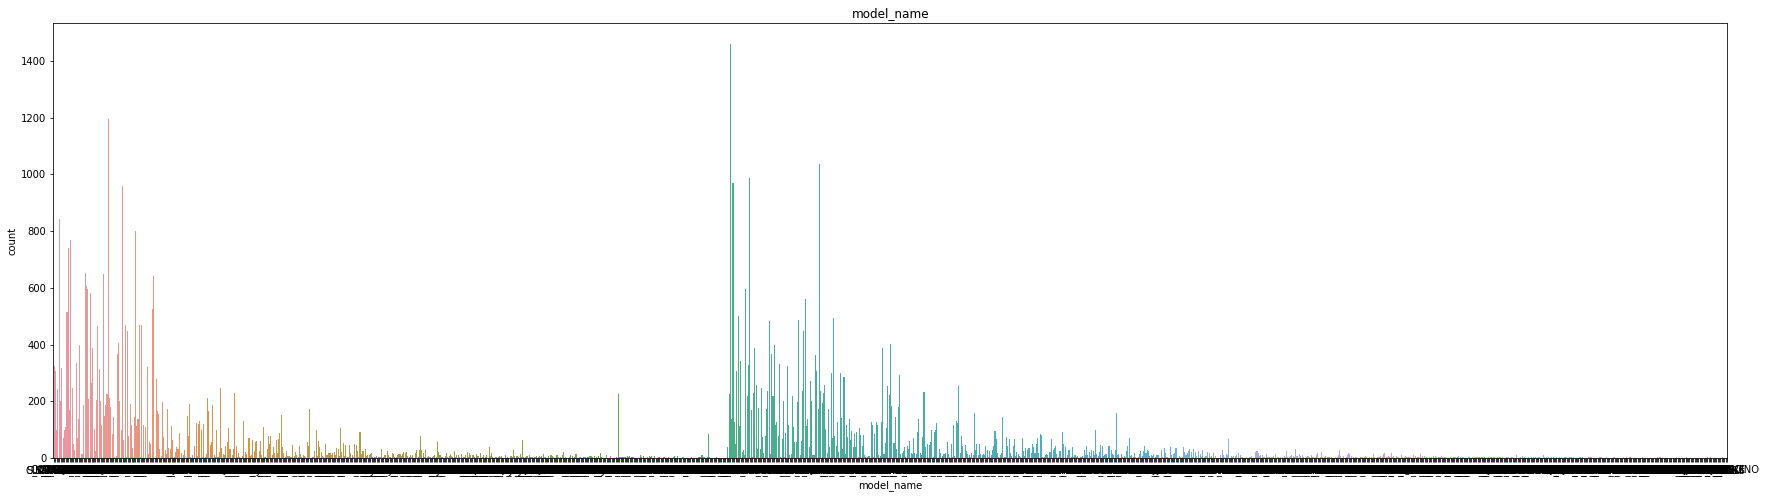

Уникальные значения для numberOfDoors:[5 3 2 4]
Количество уникальных значений для numberOfDoors:4


'Соотношение в %:'

5    90.023757
3     3.845125
4     3.673636
2     2.457482
Name: numberOfDoors, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


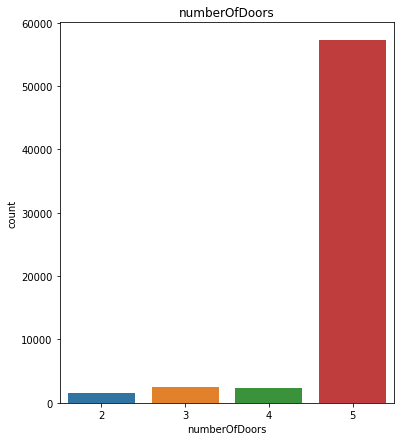

Уникальные значения для vehicleTransmission:['механическая' 'роботизированная' 'автоматическая' 'вариатор']
Количество уникальных значений для vehicleTransmission:4


'Соотношение в %:'

автоматическая      47.879989
механическая        36.796149
роботизированная     9.103066
вариатор             6.220796
Name: vehicleTransmission, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


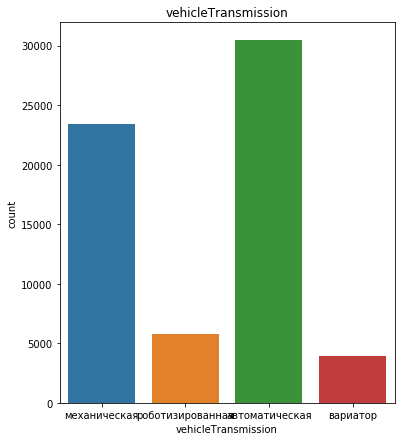

Уникальные значения для vendor:['JAPANESE' 'EUROPEAN' 'AMERICAN' 'USSR' 'KOREAN' 'CHINESE']
Количество уникальных значений для vendor:6


'Соотношение в %:'

EUROPEAN    47.448907
JAPANESE    20.188480
KOREAN      12.934032
USSR        10.605560
AMERICAN     7.043627
CHINESE      1.779393
Name: vendor, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


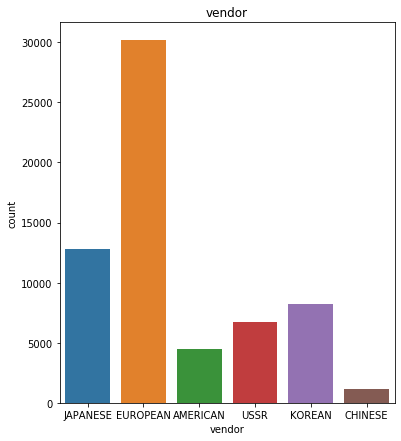

Уникальные значения для Владельцы:['3 ' '1\xa0' '2\xa0' 3]
Количество уникальных значений для Владельцы:4


'Соотношение в %:'

3     42.881641
1     30.336212
2     26.764840
3      0.017306
Name: Владельцы, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


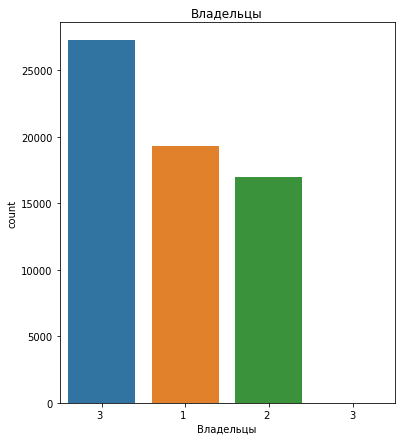

Уникальные значения для ПТС:['Оригинал' 'Дубликат']
Количество уникальных значений для ПТС:2


'Соотношение в %:'

Оригинал    86.962131
Дубликат    13.037869
Name: ПТС, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


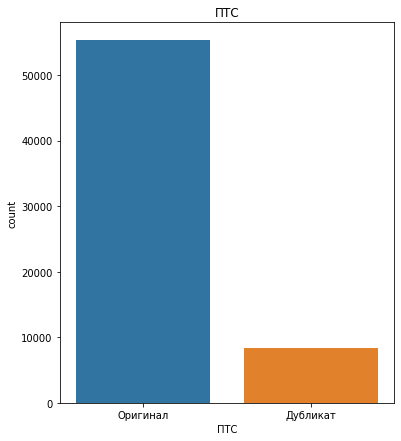

Уникальные значения для Привод:['передний' 'задний' 'полный']
Количество уникальных значений для Привод:3


'Соотношение в %:'

передний    54.192036
полный      35.144192
задний      10.663772
Name: Привод, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


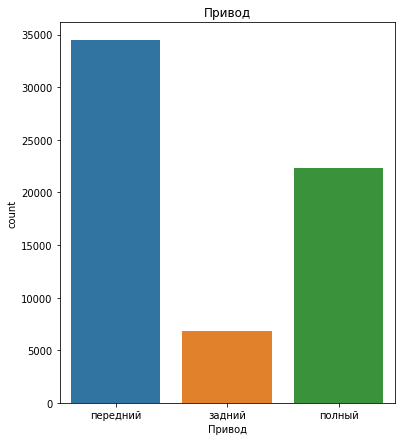

Уникальные значения для Руль:['Левый' 'Правый']
Количество уникальных значений для Руль:2


'Соотношение в %:'

Левый     97.940561
Правый     2.059439
Name: Руль, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


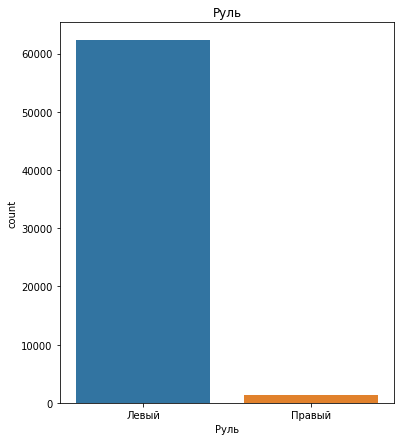

Уникальные значения для Состояние:['Не требует ремонта']
Количество уникальных значений для Состояние:1


'Соотношение в %:'

Не требует ремонта    100.0
Name: Состояние, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


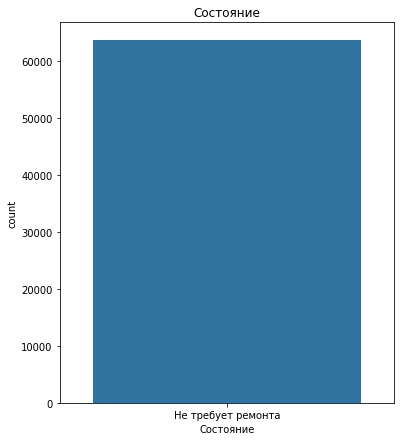

Уникальные значения для Таможня:['Растаможен' nan]
Количество уникальных значений для Таможня:1


'Соотношение в %:'

Растаможен    100.0
Name: Таможня, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


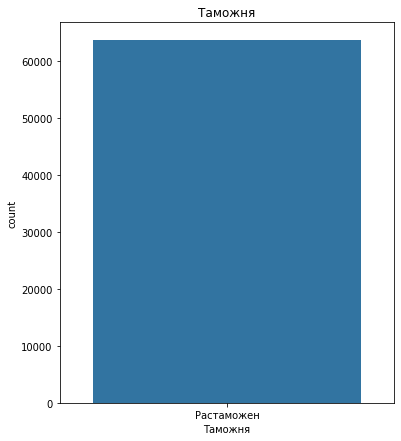

In [23]:
# Рассмотрим категориальные признаки для трейн части
for col in cat_cols:
    check_bin_cat(train, col)

### Выводы для категориальных
1. **bodyType**  Большинство машин это седаны  и 5 дв внедорожники, пропорции для тест и трейн можно сказать одинаковые
2. **brand**  для теста 12 уникальных значений, для трейн их больше. Но это сделано осознано, чтобы модель могла обучиться на большем числе данных и лучше определять различия
3. ** color** всего 16.  Самый популярный конечно черный, наименее популярные - экзотические цвета "Желтый, оранжевый, розовый", что для трейн, что для тест. Удивления это также не вызывает
4. **fuelType** всего их 5. Бензин и Дизель ожидаемо на первых местах для трейн и тест
5. **model_name** 544 значений для тест, 1297 для тест, дублей на первый взгляд нет. Тут необходимо быть осторожным с перекодировкой
5. **numberOfDoors** всего пять значений. Среди которых есть 0 для теста. с 0 надо разобраться. В основном авто 5 и 4 дверные для теста и 5 дверные для трейн
6. **vehicleTransmission** 4 значения. Около 80% это автомат и механика. В основном автомат
7. **vendor** 2 значения для тест, 6 значений для трейн, интересно будет узнать существенно ли это для модели
8. **Владельцы**  всего 3 категории. у более 40% авто было более 3 владельцев, что нормально, учитывая, что мы рассматриваем б/у. Колонка требует **пробразований - оставить только число для тест, а для трейн разобраться со странными тройками**
9. **ПТС** всего 2 категории. у большинства владельцев (86%) оригинал ПТС
10. **Привод** всего 3 категории. почти что 90% имеют передний или полный привод, что также нормально
11. **Руль** всего 2 категории. у большинства авто руль - Левый 
12. **Состояние** - все авто не требуют ремонта. Колонку надо **удалить**
13. **Таможня** - все авто растаможены. Колонку надо **удалить**

Всех значений категориальных признаков очень много, **dummy кодирование "в лоб"  даст плохой результат**, в следствие чего необходимо использовать labelencoding (или наши деревья будут путаться), либо заменять модели аутсайдеры на "Other", либо можно попробовать укрупнить классы путем объединений







In [24]:
# разберемся с количеством дверей
test[test['numberOfDoors'] == 0]
# судя по гуглу у этого авто действительно нет дверей. не будем менять

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,48000,...,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,Не требует ремонта,Растаможен


In [25]:
# разберемся с владельцами
test['Владельцы'] = test['Владельцы'].apply(lambda x: int(x[0]))

# проверим трейн
train['Владельцы'].apply(lambda x: type(x)).value_counts()

<class 'str'>    63550
<class 'int'>       11
Name: Владельцы, dtype: int64

In [26]:
# большая часть - это строка. преобразуем:
train['Владельцы'] = train['Владельцы'].astype(int)

In [27]:
# Удалим лишнии колонки
test.drop(['Состояние', 'Таможня'], axis=1, inplace=True)
train.drop(['Состояние', 'Таможня'], axis=1, inplace=True)

In [28]:
# также исключим их из списка с категориальными признаками
cat_cols = list(set(cat_cols)-set(['Состояние', 'Таможня']))

**3. рассмотрим числовые переменные**

In [29]:
# преобразуем колонки engineDisplacement и enginePower для тест
test['enginePower'] = test.enginePower.apply(lambda x: x[:-3]).astype('float')

In [30]:
# в процессе проверки оказалось, что engineDisplacement содержит пропуск данных:
test[test['engineDisplacement'] == ' LTR']['fuelType'].head(3)

5241    электро
7992    электро
8252    электро
Name: fuelType, dtype: object

In [31]:
# как оказалось это электрокары, у которых действительно нет этого параметра. Заменим его на 0
test['engineDisplacement'] = test.engineDisplacement.apply(
    lambda x: x.split(sep=' ')[0])
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: 0 if x == '' else x).astype('float')

Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

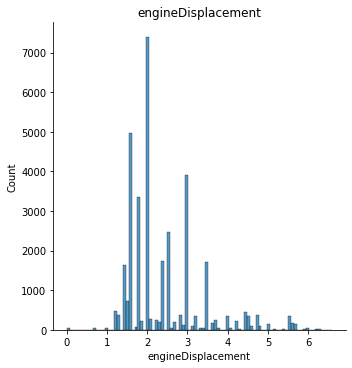

для колонки:engineDisplacement 
Границы выбросов:[2.220446049250313e-16, 4.8] 
Количество выбросов:1041
Минимальное значение:0.0, Максимальное значение:6.6
Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

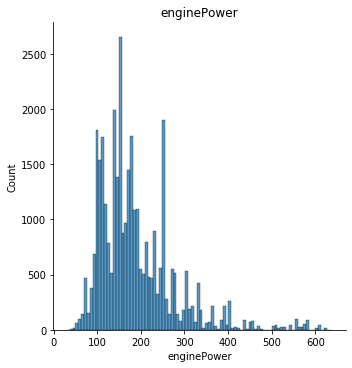

для колонки:enginePower 
Границы выбросов:[-37.0, 395.0] 
Количество выбросов:1219
Минимальное значение:30.0, Максимальное значение:639.0
Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

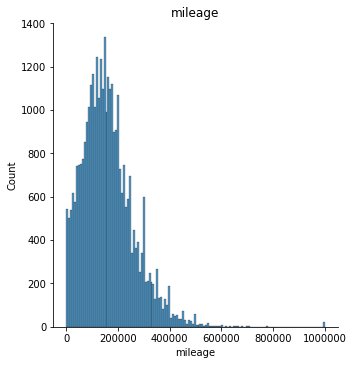

для колонки:mileage 
Границы выбросов:[-94616.25, 400769.75] 
Количество выбросов:692
Минимальное значение:1, Максимальное значение:1000000


In [32]:
# Посмотрим на распределение признаков БЕЗ логарифмирования для тест
for col in num_cols:
    check_nums(test, col)

Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

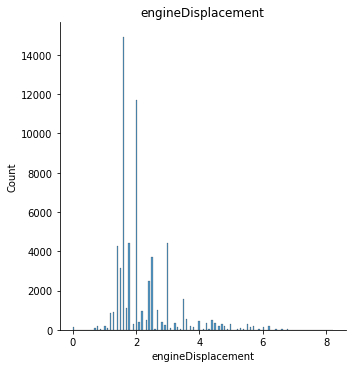

для колонки:engineDisplacement 
Границы выбросов:[0.2500000000000002, 3.8499999999999996] 
Количество выбросов:4129
Минимальное значение:0.0, Максимальное значение:8.2
Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

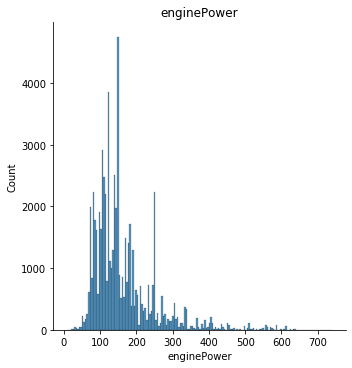

для колонки:enginePower 
Границы выбросов:[-20.0, 316.0] 
Количество выбросов:3579
Минимальное значение:8.0, Максимальное значение:740.0
Данные НЕ были прологарифмированы!


<Figure size 576x576 with 0 Axes>

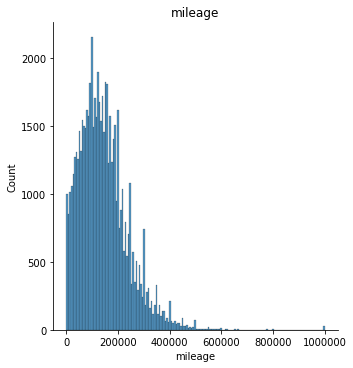

для колонки:mileage 
Границы выбросов:[-102500.0, 373500.0] 
Количество выбросов:1462
Минимальное значение:1.0, Максимальное значение:1000000.0


In [33]:
# Посмотрим на распределение признаков БЕЗ логарифмирования для трейн
for col in num_cols:
    check_nums(train, col)

Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

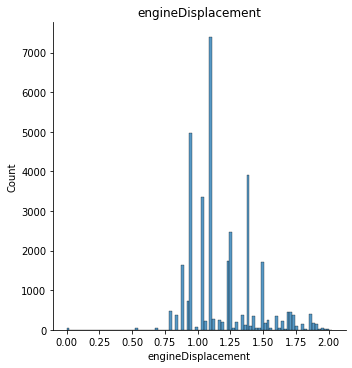

для колонки:engineDisplacement 
Границы выбросов:[0.49460700127305945, 1.9213067770279892] 
Количество выбросов:162
Минимальное значение:0.0, Максимальное значение:2.028148247292285
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

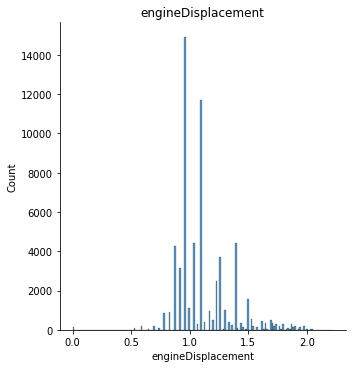

для колонки:engineDisplacement 
Границы выбросов:[0.5096341598255387, 1.6986402536972656] 
Количество выбросов:2758
Минимальное значение:0.0, Максимальное значение:2.2192034840549946
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

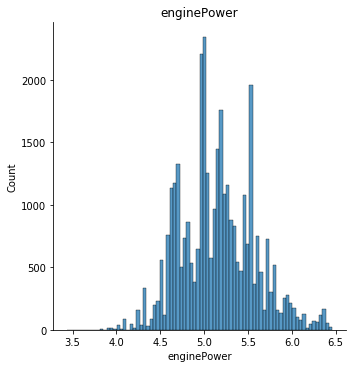

для колонки:enginePower 
Границы выбросов:[3.9077230943421424, 6.383879927967037] 
Количество выбросов:88
Минимальное значение:3.4339872044851463, Максимальное значение:6.461468176353717
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

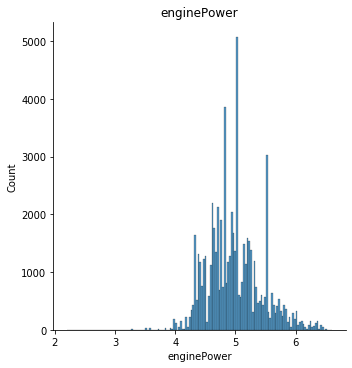

для колонки:enginePower 
Границы выбросов:[3.8036619440848196, 6.121440318423716] 
Количество выбросов:1027
Минимальное значение:2.1972245773362196, Максимальное значение:6.608000625296087
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

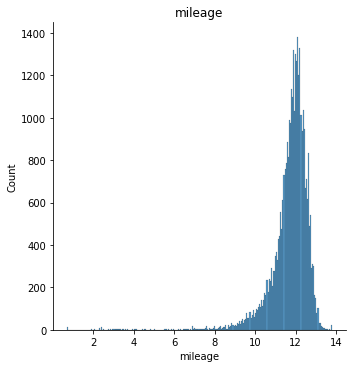

для колонки:mileage 
Границы выбросов:[10.133180927228787, 13.565528176881566] 
Количество выбросов:1808
Минимальное значение:0.6931471805599453, Максимальное значение:13.815511557963774
Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

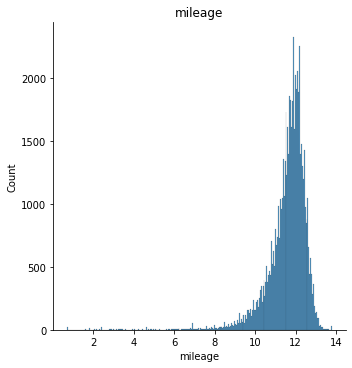

для колонки:mileage 
Границы выбросов:[9.825114494084808, 13.594147248729698] 
Количество выбросов:3023
Минимальное значение:0.6931471805599453, Максимальное значение:13.815511557963774


In [34]:
# Посмотрим на распределение признаков С логарифмированием
for col in num_cols:
    check_nums(test, col, log=True), check_nums(train, col, log=True)

### Выводы для числовых
1. **engineDisplacement** распределение не выглядит нормальным, логарифмирование не сильно помогает. В основном двигатели имеют объем от 1 до 4 литров. Выбросы на первый взгляд есть, но на смом деле все в рамках нормы для авто
2. **enginePower** логарифмирование возможно помогает! Выбросы хоть и присутствуют, но если разобраться все в целом в рамках нормы
3. **mileage** кажется что для данной переменной логарифмирование работает лучше всего. Разброс данных очень большой, потому что авто у нас все б.у. , выбросы пока не будем трогать.

**4. рассмотрим даты**

In [35]:
# преобразуем колонку parsing_unixtime, так как она говорит о том, когда скачано объявление, т.е. грубо говоря, когда авто выставлено на продажу
# pd.Timestamp(test['parsing_unixtime'],unit='s')
tt = test['parsing_unixtime'].apply(lambda x: pd.Timestamp(x, unit='s'))
# tt.dt.year.value_counts()
# tt.dt.month.value_counts()

# все в 2020 году и в 10 месяце

2010    2503
2013    2275
2008    2243
2011    2173
2006    2169
        ... 
1960       1
1973       1
1904       1
1963       1
1965       1
Name: modelDate, Length: 66, dtype: int64

 1     9227
 2     8682
 3     6512
 0     4076
 4     3629
 5     1474
 6      524
 7      237
 8      153
 9       60
 11      33
 10      31
 13      13
 12      12
 15       6
 14       3
-1        3
-2        2
 35       2
 34       2
 46       1
 16       1
 18       1
 22       1
 27       1
dtype: int64

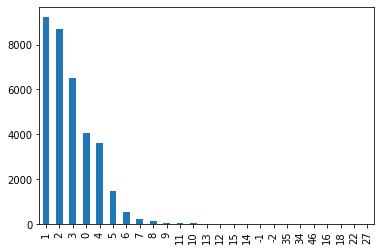

In [36]:
display(test['modelDate'].value_counts())
display((test['productionDate']-test['modelDate']).value_counts())
(test['productionDate']-test['modelDate']).value_counts().plot(kind='bar')

Text(0.5, 1.0, 'TRAIN')

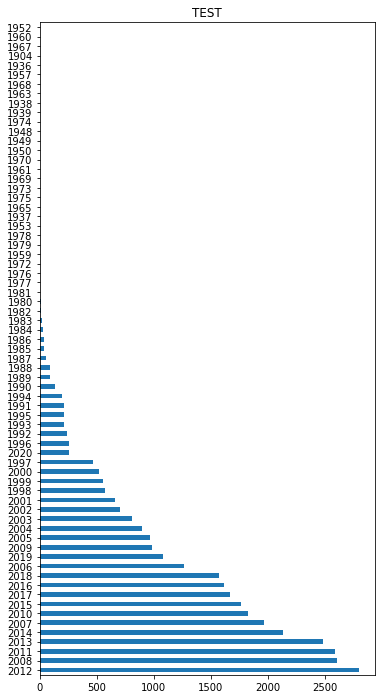

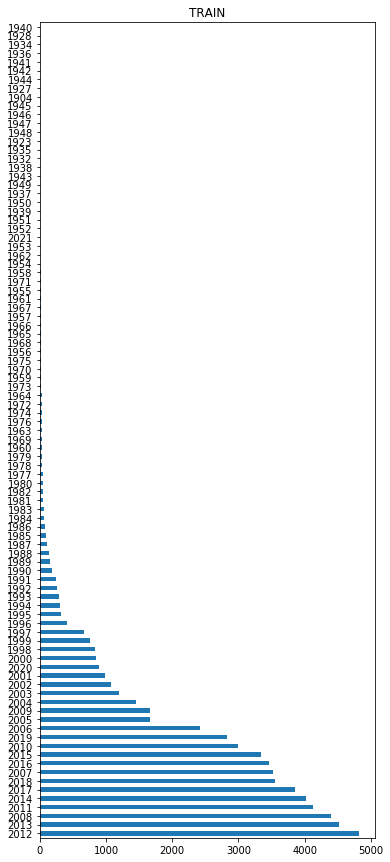

In [37]:
# Взглянем на productionDate для тест и трейн
plt.figure(figsize=(6, 12))
test['productionDate'].value_counts().plot(kind='barh')
plt.title('TEST')

plt.figure(figsize=(6, 15))
train['productionDate'].value_counts().plot(kind='barh')
plt.title('TRAIN')

### Выводы для дат
1. разница между modelDate  и productionDate не столь значительно, скорее всего нам она будет не принципиальна, тем более, что для трейна у нас нет этой инфо
2. сама **productionDate** можеть быть интересна,  возможно для модели будет интересна *разница между текущим годом и  productionDate*, так как очевидно, что чем больше лет авто, тем оно дешевле, если конечно это не раритет.
3. **parsing_unixtime** также удалим,если понадобится год, воспользуемся текущим


In [38]:
test.drop(['modelDate', 'parsing_unixtime'], axis=1, inplace=True), train.drop(
    ['parsing_unixtime'], axis=1, inplace=True)

(None, None)

**5. рассмотрим колонки содержащее то, что мы не смогли ранее однозначно классифицировать**

In [39]:
# name
test[['name', 'engineDisplacement', 'enginePower']].sample(5)
# комбинация столбцов engineDisplacement и enginePower. Так как там пропусков не наблюдается, удалим

,name,engineDisplacement,enginePower
2617,55 TFSI 3.0 AT (340 л.с.) 4WD,3.0,340.0
9277,520d xDrive 2.0d AT (190 л.с.) 4WD,2.0,190.0
5128,2.4 CVT (177 л.с.),2.4,177.0
21844,2.5 AT (181 л.с.),2.5,181.0
30386,3.0d AT (245 л.с.) 4WD,3.0,245.0


In [40]:
# vehicleConfiguration
test['vehicleConfiguration'].sample(5)
# опять комбинация колонок. удалим

26188               VAN MECHANICAL 2.5
1073            LIFTBACK AUTOMATIC 1.6
9412     ALLROAD_5_DOORS AUTOMATIC 3.0
1480           LIFTBACK MECHANICAL 1.2
6414               SEDAN AUTOMATIC 2.0
Name: vehicleConfiguration, dtype: object

In [41]:
# super_gen
test['super_gen'].sample(5).values
# содержит интересные параметры - acceleration, clearance_min, fuel_rate
# возможно их будет стоить добавить в модель. Пока удалим, как их парсить для трейн я не понял пока

array(['{"id":"4995255","name":"240","nameplate":"240","displacement":2398,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"MECHANICAL","power":170,"power_kvt":125,"human_name":"240 2.4 MT (170 л.с.)","acceleration":9.8,"clearance_min":160,"fuel_rate":10.8}',
       '{"id":"9364354","displacement":2354,"engine_type":"GASOLINE","gear_type":"ALL_WHEEL_DRIVE","transmission":"AUTOMATIC","power":190,"power_kvt":140,"human_name":"2.4 AT (190 л.с.) 4WD","acceleration":10.7,"clearance_min":175,"fuel_rate":8.4}',
       '{"id":"2625833","name":"525","nameplate":"525i","displacement":2497,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"AUTOMATIC","power":218,"power_kvt":160,"human_name":"525i 2.5 AT (218 л.с.)","acceleration":7.9,"clearance_min":142,"fuel_rate":9.4}',
       '{"id":"4602027","displacement":1497,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":98,"power_kvt":72,"human_name":"1.5 MT (98 л.с.)","accelerati

In [42]:
test.drop(['name', 'vehicleConfiguration', 'super_gen'], axis=1, inplace=True)
# удалим также complectation_dict как решили ранее + model_info (опять дубли информации)
test.drop(['complectation_dict', 'model_info'], axis=1, inplace=True)

#### equipment_dict
как мы уже помним содержит комплектацию для авто для тех, кто не поленился ее заполнить

In [43]:
# вытащим сведения о комплектации, Которые есть в тест и трейн
# test
import re
equip = test['equipment_dict'].str.findall(
    r'\w+-?\w+\w+-?\w+-?\w+-?\w+-?\w+-?')
equip = equip.fillna('Nothing')
equip = equip.apply(lambda x: None if x ==
                    'Nothing' else list(set(x)-set(['true'])))
equip_list_test = equip.explode()

# train
equip_list_train = train['equipment_dict'].str.findall(
    r'([ 0-90-9А-яё-]+)').explode()

In [44]:
# посмотрим, какие наименее распостраненные опции в комплектации есть
# это представляется мне более логичным, так как чем опции реже, тем скорее они есть в премиум авто, чем в более дешевых
# потому что делать кондиционеры все худо-бедно научились, а вот камеры 360 град нет
# также мы решим проблему с незаполненными комплектациями (скорее всего), так как для "навороченных" авто владелец скорее всего ее заполнит
# брать будем не все подряд,а так чтобы захватить как можно больше авто класса премиум и чуть ниже, или мы возьмем только очень премиум
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
display(equip_list_test.value_counts().tail(100))
print('='*70)
display(equip_list_train.value_counts().tail(100))

seat-memory                                      3206
16-inch-wheels                                   2912
18-inch-wheels                                   2886
steering-wheel-gear-shift-paddles                2794
e-adjustment-wheel                               2774
voice-recognition                                2448
multizone-climate-control                        2426
paint-metallic                                   2426
audiopreparation                                 2268
light-interior                                   2247
front-seats-heat-vent                            2199
decorative-interior-lighting                     2126
sport-seats                                      2077
driver-seat-memory                               2035
black-roof                                       1980
panorama-roof                                    1943
front-seat-support                               1925
reduce-spare-wheel                               1864
electronic-gage-panel       

Подогрев задних сидений                         5392
Стальные диски                                  5344
Металлик                                        4963
Аудиоподготовка                                 4818
Премиальная аудиосистема                        4759
Диски 18                                        4712
Система управления дальним светом               4678
Память передних сидений                         4561
Подрулевые лепестки переключения передач        4509
Количество мест                                 4236
Голосовое управление                            4054
Система помощи при торможении                   4021
Светлый салон                                   3679
Комбинированный                                 3667
Фаркоп                                          3449
Электрорегулировка руля                         3432
Климат-контроль многозонный                     3389
Сигнализация с обратной связью                  3325
Диски 15                                      

In [45]:
# далее произведем создание списков и колонок с отобранными элементами комплектации
train_use_equip = ['Камера передняя', 'Бронированный кузов', 'Лазерные фары', 'Система ночного видения', 'Алькантара', 'Регулируемый педальный узел', 'Спортивная подвеска', 'Проекционный дисплей', 'Система распознавания дорожных знаков',
                   'Электрорегулировка сиденья водителя', 'Открытие багажника без помощи рук', 'Система контроля за полосой движения', 'Адаптивный круиз-контроль', 'Камера 360', 'Память сиденья водителя', 'Панорамная крыша', 'Стальные диски']
test_use_equip = ['front-camera', 'armored', 'laser-lights', 'night-vision', 'alcantara', 'adj-pedals', 'sport-suspension', 'projection-display', 'traffic-sign-recognition',
                  'driver-seat-electric', 'easy-trunk-opening', 'lane-keeping-assist', 'auto-cruise', '360-camera', 'driver-seat-memory', 'panorama-roof', 'steel-wheels']

# и вместо пропусков в колонке equipment_dict укажем Nothing, чтобы функция корректно отрабатывала
test['equipment_dict'].fillna('nothing', inplace=True)
train['equipment_dict'].fillna('nothing', inplace=True)

# напишем функцию и пока сохраним данные в отдельные датасеты


def find_item(cell):
    if equip in cell:
        return 1
    return 0


train_equipment = train[['equipment_dict']].copy()
test_equipment = test[['equipment_dict']].copy()

for equip in train_use_equip:
    train_equipment[equip] = train['equipment_dict'].apply(find_item)

for equip in test_use_equip:
    test_equipment[equip] = test['equipment_dict'].apply(find_item)

# наконец переименуем колонки, чтобы не было противоречия с тестовой частью
train_equipment.columns = ['equipment_dict', 'front-camera', 'armored', 'laser-lights', 'night-vision', 'alcantara', 'adj-pedals', 'sport-suspension', 'projection-display',
                           'traffic-sign-recognition', 'driver-seat-electric', 'easy-trunk-opening', 'lane-keeping-assist', 'auto-cruise', '360-camera', 'driver-seat-memory', 'panorama-roof', 'steel-wheels']
train_equipment.head(1)

,equipment_dict,front-camera,armored,laser-lights,night-vision,alcantara,adj-pedals,sport-suspension,projection-display,traffic-sign-recognition,driver-seat-electric,easy-trunk-opening,lane-keeping-assist,auto-cruise,360-camera,driver-seat-memory,panorama-roof,steel-wheels
0,"['Защита картера', 'Полноразмерное запасное ко...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Выводы для "неоднозначных" колонок
1. колонку **description** было решено удалить, так как мы не смогли вытащить из него полезных признаков
2. **equipment_dict** - мы вычленили ряд признаков, которые не слишком распространены. Возможно это поможет модели выделить более или менее дорогие авто. Пока данные сохранены в отдельных датасетах-train_equipment и test_equipment
3. Прочие неоднозначные колонки также были удалены

In [46]:
# удалим description
test.drop(['description'], axis=1, inplace=True), train.drop(
    ['description'], axis=1, inplace=True)

(None, None)

## Отбор признаков для модели

посмотрим на корреляцию для числовых признаков и проведем ttest + построим боксплоты для категориальных колонок

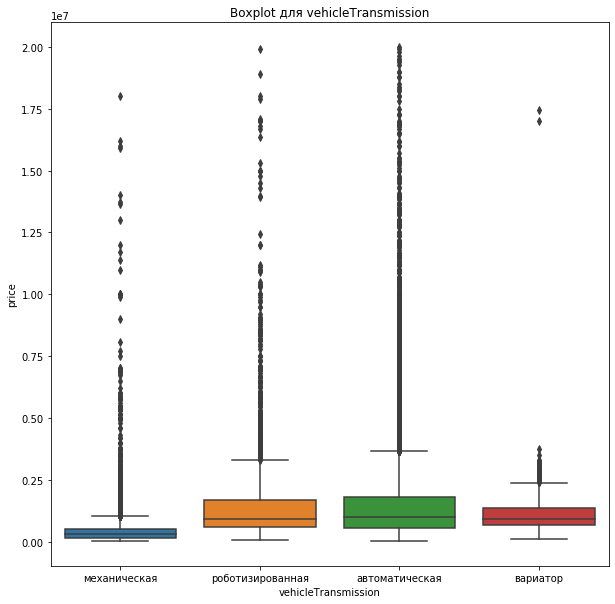

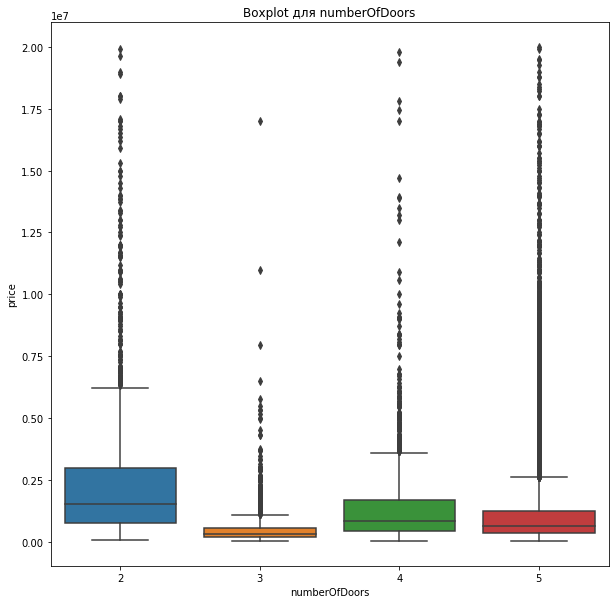

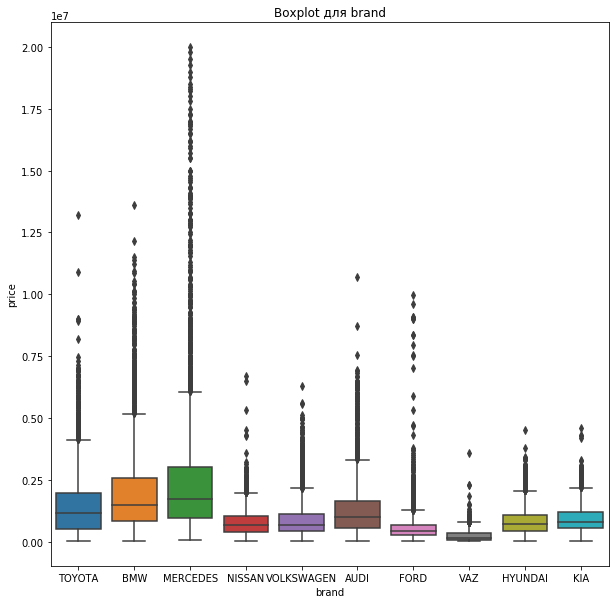

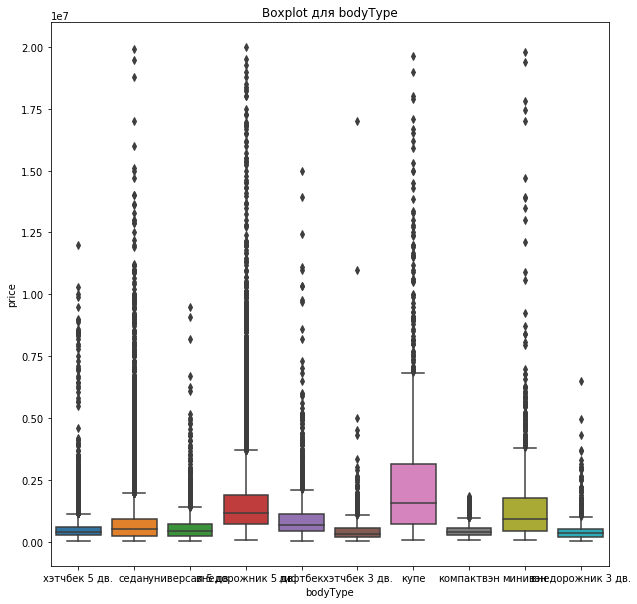

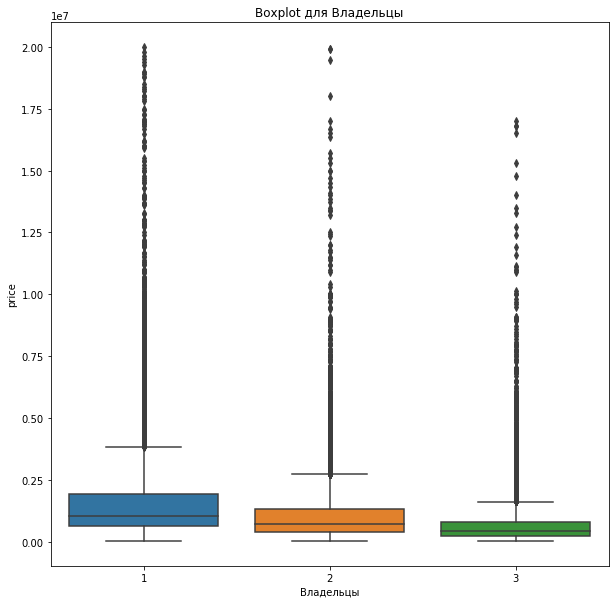

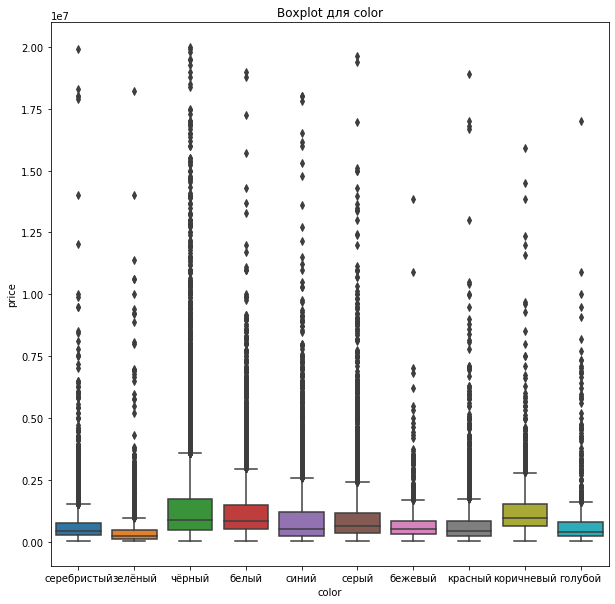

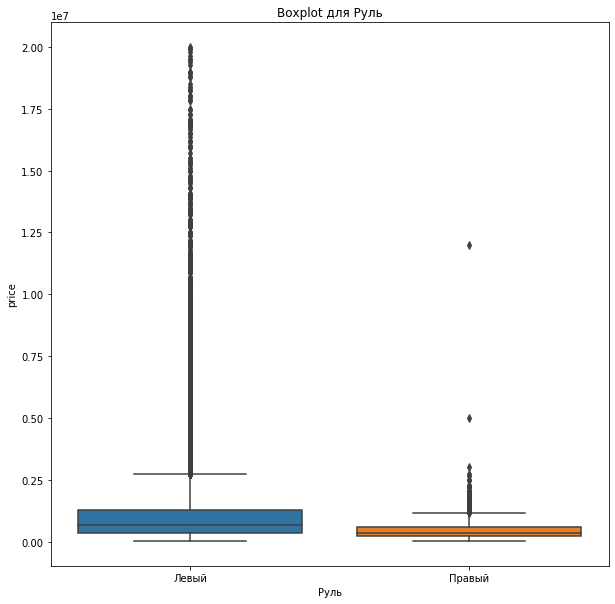

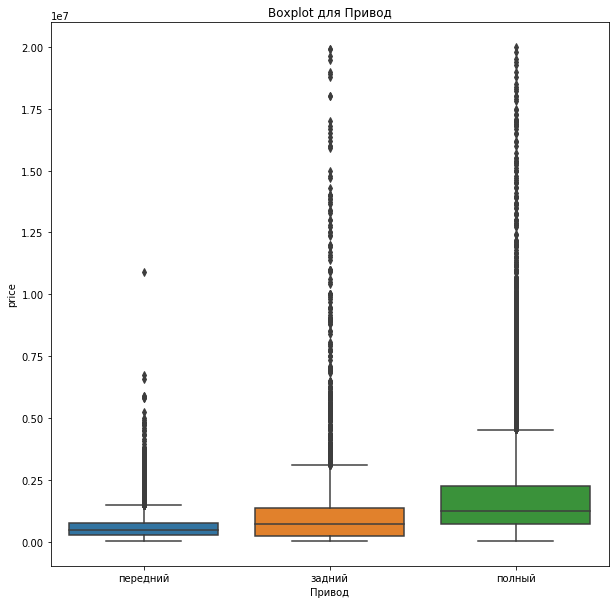

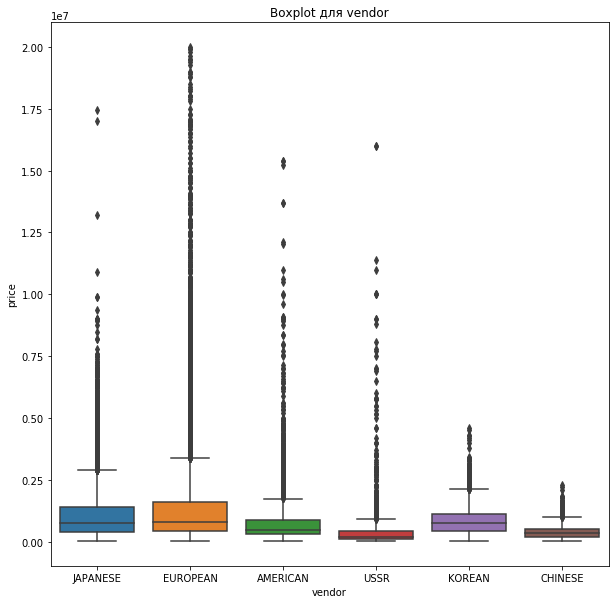

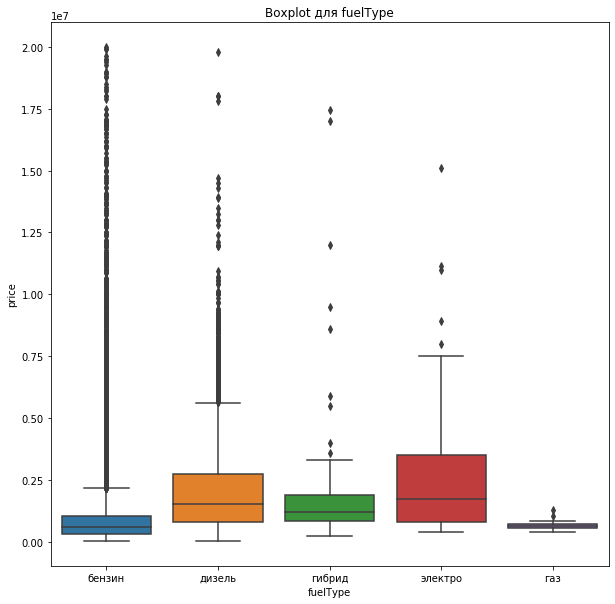

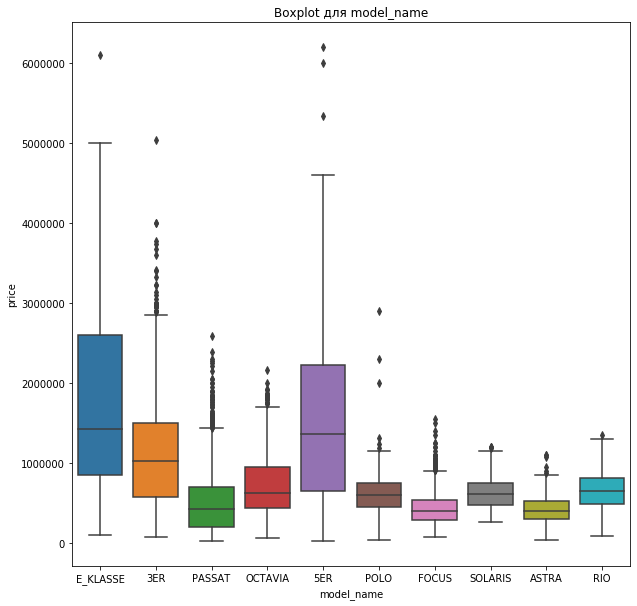

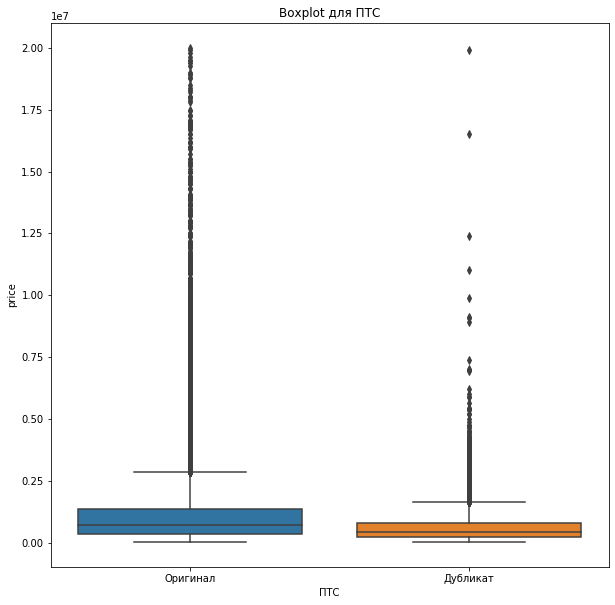

In [47]:
# категориальные
for col in cat_cols:
    boxplot(col)

In [48]:
for column in cat_cols:
    get_stat_dif2(column)

Найдены важные статистические различия для vehicleTransmission
Найдены важные статистические различия для numberOfDoors
Найдены важные статистические различия для brand
Найдены важные статистические различия для bodyType
Найдены важные статистические различия для Владельцы
Найдены важные статистические различия для color
Найдены важные статистические различия для Руль
Найдены важные статистические различия для Привод
Найдены важные статистические различия для vendor
Найдены важные статистические различия для fuelType
Найдены важные статистические различия для model_name
Найдены важные статистические различия для ПТС


**Выводы:** Все категориальные признаки по мнению ттеста важны, боксплоты этому мнению не противоречат. Таким образом все признаки берем для модели 

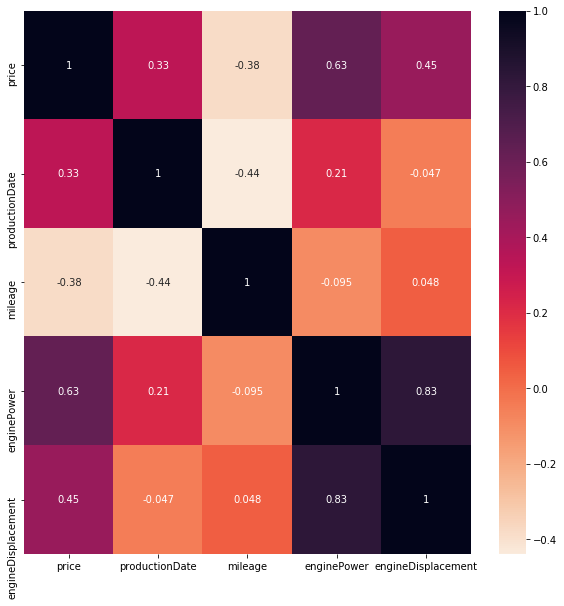

In [49]:
# числовые признаки
correlation = train[set(train.columns)-set(cat_cols)].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, cmap='rocket_r', annot=True)

**Выводы:** у всех числовых признаков наблюдается корреляция с целевой переменной, так что тоже все возьмем в модель. отметим корреляцию между объемом двигателя и его мощностью. Это не вызывает удивления 

## Предобработка для построения модели числовых признаков
- Для всех категориальных признаков воспользуемся label encoding в лоб. 
- Если результат нас не устроит (и хватит времени) попробуем реализовать более сложную стратегию с присвоением малораспространенным признакам значений типо other  и т.д

In [50]:
df_model_1 = train.copy()
df_model_1.drop(['equipment_dict'], axis=1, inplace=True)

In [51]:
label = preprocessing.LabelEncoder()
# уберем категориальные признаки, которые уже выражены числами
cat_cols = list(set(cat_cols)-set(['Владельцы', 'numberOfDoors']))

# воспользуемся labelencoding
for cat in cat_cols:
    df_model_1[cat] = label.fit_transform(df_model_1[cat])

## Построение моделей
### Первая модель
- самый обычный decision tree с Бэггинг\
это будет неким бейслайном
- далее попробуем прочие алгоритмы МО - лес, бустинг и возможно стэкинг
- далее во второй модели попробуем поработать с признаками


In [52]:
X = df_model_1[set(df_model_1.columns)-set(['price', 'city'])].values
y = df_model_1['price'].values

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [54]:
# создадим дерево и сразу завернем все в бэггинг
tree = DecisionTreeRegressor(random_state=42)
bagging = BaggingRegressor(
    base_estimator=tree, n_estimators=10, random_state=42, n_jobs=-1)
bagging.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, bagging.predict(X_train))
print('Валидационая выборка')
mape(y_valid, bagging.predict(X_valid))

# модель ожидаемо переобучилась, но меньше чем с обычным деревом (MAPE: 25.408 на валидации)
# будем использовать данные показатели как бейслайн, попробуем улучшить их

Обучающая выборка
MAPE: 8.21049753849232
Валидационая выборка
MAPE: 20.76462613348478


Обучающая выборка
MAPE: 7.410370063948601
Валидационая выборка
MAPE: 19.791614944180818


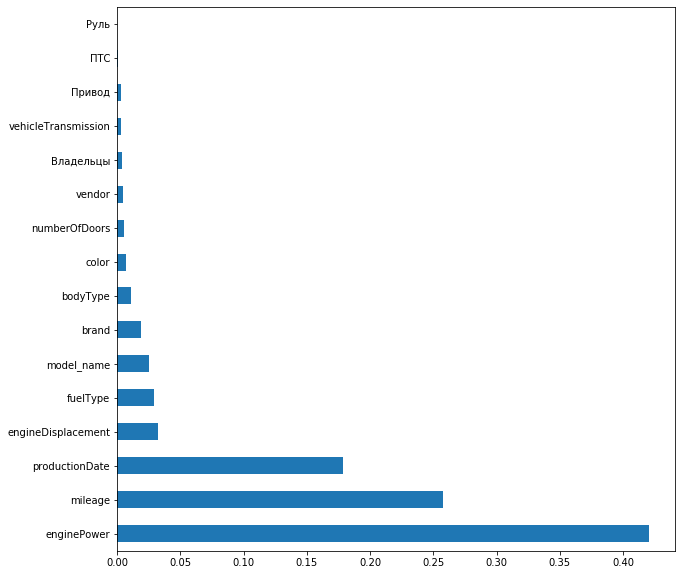

In [55]:
# случайный лес
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, rfr.predict(X_train))
print('Валидационая выборка')
mape(y_valid, rfr.predict(X_valid))

# построим визуализацию важности признаков
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(rfr.feature_importances_, index=df_model_1[set(
    df_model_1.columns)-set(['price', 'city'])].columns)
feat_importances.nlargest(30).plot(kind='barh')

- Модель также переобучается, но уже в меньшей степени. 
- Попробуем подобрать оптимальные параметры для Леса

In [56]:
# градиентный бустинг
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, gb.predict(X_train))
print('Валидационая выборка')
mape(y_valid, gb.predict(X_valid))

Обучающая выборка
MAPE: 31.54693619994786
Валидационая выборка
MAPE: 32.212097725334566


In [57]:
# xgb бустинг
xgboost = XGBRegressor(random_state=42, n_jobs=-1)
xgboost.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, xgboost.predict(X_train))
print('Валидационая выборка')
mape(y_valid, xgboost.predict(X_valid))

Обучающая выборка
MAPE: 18.56160866707445
Валидационая выборка
MAPE: 21.46027181459436


In [58]:
# lightgbm бустинг
lbm = LGBMRegressor(random_state=42, n_jobs=-1)
lbm.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, lbm.predict(X_train))
print('Валидационая выборка')
mape(y_valid, lbm.predict(X_valid))

Обучающая выборка
MAPE: 22.906211742626294
Валидационая выборка
MAPE: 23.935765405190523


In [59]:
# Экстремальный случайный лес
erfr = ExtraTreesRegressor(random_state=42, n_jobs=-1)
erfr.fit(X_train, y_train)

print('Обучающая выборка')
mape(y_train, erfr.predict(X_train))
print('Валидационая выборка')
mape(y_valid, erfr.predict(X_valid))

Обучающая выборка
MAPE: 0.03204364887952774
Валидационая выборка
MAPE: 20.58393937750232


пока случайный лес показал себя лучше всех, но мы не работали с гиперпараметрами. Тем не менее, получив базу, попробуем добавить новые признаков в модель

### Вторая модель
### Feature engineering*
*тестовый сет будем преобразовывать также сразу\
доп признаки добавлялись по очереди

In [60]:
df_model_2 = train.copy()
df_model_2.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,city
0,хэтчбек 5 дв.,TOYOTA,серебристый,1.4,97.0,"['Защита картера', 'Полноразмерное запасное ко...",бензин,315000.0,COROLLA,5,2006,механическая,JAPANESE,3,Оригинал,передний,Левый,380000.0,MSK
1,седан,BMW,зелёный,3.4,211.0,nothing,бензин,315900.0,7ER,5,1990,механическая,EUROPEAN,3,Дубликат,задний,Левый,590000.0,MSK


In [61]:
# уберем "city"
df_model_2.drop(['city'], axis=1, inplace=True)

In [62]:
# пробуем рассчитать транспортный налог
# для электромобилей его нет
def tax(row):
    if row['fuelType'] == 'электро':
        return 0
    else:
        if row['enginePower'] > 250:
            return row['enginePower']*15

        elif row['enginePower'] > 200 and row['enginePower'] <= 250:
            return row['enginePower']*7.5

        elif row['enginePower'] > 150 and row['enginePower'] <= 200:
            return row['enginePower']*5

        elif row['enginePower'] > 100 and row['enginePower'] <= 150:
            return row['enginePower']*3.5

        elif row['enginePower'] <= 100:
            return row['enginePower']*2.5


df_model_2['tax'] = df_model_2.apply(lambda row: tax(row), axis=1)
test['tax'] = test.apply(lambda row: tax(row), axis=1)

Данные были прологарифмированы!


<Figure size 576x576 with 0 Axes>

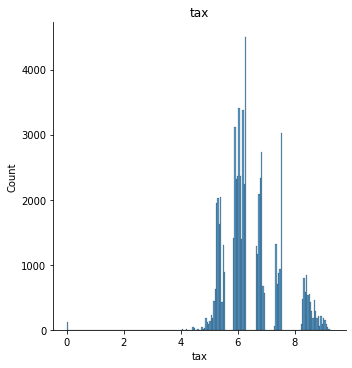

для колонки:tax 
Границы выбросов:[4.526819926304796, 8.239017067553728] 
Количество выбросов:6870
Минимальное значение:0.0, Максимальное значение:9.314790473332646


In [63]:
check_nums(df_model_2, 'tax', log=True)

# кажется его лучше прологарифмировать
df_model_2['tax'] = df_model_2['tax'].apply(lambda x: np.log(x+1))
test['tax'] = test['tax'].apply(lambda x: np.log(x+1))

In [64]:
# возраст
df_model_2['OLD'] = df_model_2['productionDate'].apply(lambda x: 2021-x)
test['OLD'] = test['productionDate'].apply(lambda x: 2021-x)
# конечно добавили мультиколлинеарности, но так вроде выходит лучше

In [65]:
# создадим фиктивный признак - enginePower**OLD
df_model_2['enginePower**OLD'] = df_model_2.apply(
    lambda row: row['enginePower']**(1/(row['OLD']+1)), axis=1)
test['enginePower**OLD'] = test.apply(
    lambda row: row['enginePower']**(1/(row['OLD']+1)), axis=1)

num_cols.append('enginePower**OLD')

In [66]:
# попробуем добавить рейтинг автопроизводителей мировой. Мы же на это ориентируеся при выборе авто (?)
# также у более популярных (выпускаемых) авто легче найти обслуживание и детали, конечно ferrari и tesla пока не попадут в топ из за малораспространенности
rating = {'TOYOTA': 2, 'BMW': 10, 'MERCEDES': 9, 'VOLVO': 12, 'SKODA': 1, 'NISSAN': 3, 'LEXUS': 2, 'VOLKSWAGEN': 1, 'HONDA': 7, 'AUDI': 1, 'MITSUBISHI': 3, 'INFINITI': 3, 'CITROEN': 8, 'LAND_ROVER': 16, 'FORD': 6, 'VAZ': 18, 'HYUNDAI': 5, 'OPEL': 8, 'GAZ': 18, 'CHERY': 17, 'CHEVROLET': 4, 'DAEWOO': 18, 'KIA': 5, 'MAZDA': 13, 'CHRYSLER': 8, 'SUBARU': 14, 'GREAT_WALL': 15, 'JEEP': 8, 'RENAULT': 3, 'MINI': 10, 'DODGE': 8, 'ISUZU': 18, 'BYD': 18, 'LINCOLN': 6, 'PORSCHE': 1, 'SUZUKI': 11,
          'UAZ': 18, 'LIFAN': 18, 'JAGUAR': 16, 'SMART': 9, 'PEUGEOT': 8, 'DATSUN': 3, 'RAVON': 18, 'MOSCVICH': 18, 'HAVAL': 15, 'DAIHATSU': 18, 'PONTIAC': 4, 'ROVER': 6, 'GEELY': 12, 'GENESIS': 5, 'SEAT': 1, 'CADILLAC': 4, 'LAMBORGHINI': 1, 'FIAT': 8, 'MASERATI': 8, 'BENTLEY': 1, 'ROLLS_ROYCE': 10, 'ALFA_ROMEO': 8, 'FERRARI': 18, 'VORTEX': 18, 'FAW': 18, 'DONGFENG': 15, 'ACURA': 7, 'HUMMER': 4, 'GMC': 4, 'BRILLIANCE': 18, 'TESLA': 18, 'CHANGAN': 14, 'DACIA': 18, 'BUICK': 4, 'DAIMLER': 9}

df_model_2['rating'] = df_model_2.brand.replace(to_replace=rating)
test['rating'] = test.brand.replace(to_replace=rating)

In [67]:
# добавим в датасте, которые мы создали по equipment dict, сумму колонок, чтобы отметить авто с большей комплектацией для выбранных элементов
train_equipment['all_sum'] = train_equipment.sum(axis=1)
test_equipment['all_sum'] = test_equipment.sum(axis=1)

In [68]:
# объеденим датасет с теми признаками, которые мы создали по equipment dict
# лучше брать часть признаков, как показала практика
df_model_2 = pd.concat([df_model_2, train_equipment[[
                       'panorama-roof', '360-camera', 'driver-seat-memory', 'all_sum']]], axis=1)
test = pd.concat([test, test_equipment[['panorama-roof',
                                        '360-camera', 'driver-seat-memory', 'all_sum']]], axis=1)

In [69]:
# поработаем с выбросами engineDisplacement - будем считать выбросами, все, что больше 6.9
df_model_2 = df_model_2[df_model_2['engineDisplacement'] <= 6.9]

In [70]:
# попробуем логарифмировать колонки
# mileage
df_model_2['mileage'] = df_model_2['mileage'].apply(lambda x: np.log(x+1))
test['mileage'] = test['mileage'].apply(lambda x: np.log(x+1))

# enginePower**OLD
df_model_2['enginePower**OLD'] = df_model_2['enginePower**OLD'].apply(
    lambda x: np.log(x))
test['enginePower**OLD'] = test['enginePower**OLD'].apply(lambda x: np.log(x))

# price
df_model_2['price'] = df_model_2['price'].apply(lambda x: np.log(x))

In [71]:
df_model_2.drop(['equipment_dict'], axis=1, inplace=True), test.drop(
    ['equipment_dict'], axis=1, inplace=True)

(None, None)

Разберемся с dummy кодирование для категориальных переменных. labelencoding тоже работает, но он фактически ранговые признаки там где их нет. Например бренд.
Если мы сделаем все dummy, то у нас будет слишком много колонок. Модель ухудшит предсказания.\
Будем пытаться балансировать. Используем dummy для большинства значений в колонке, если популярный тренд можно выделить. Остальные сделаем other. для колонок без ярко выраженных трендов и где много значений, будем пытаться использовать labelencoding\
**путного не вышло из идеи** либо плюсы были неоднозначны. оставим для истории код ниже 

In [72]:
# display(train['fuelType'].value_counts(normalize=True))
# display(test['fuelType'].value_counts(normalize=True))

# используем бензин, дизель, other
# df_model_2['fuelType']=df_model_2['fuelType'].apply(lambda x: 'other' if x not in ['бензин','дизель'] else x)
# display(df_model_2['fuelType'].value_counts(normalize=True))

# преобразуем
# df_model_2= pd.get_dummies(df_model_2, columns=['fuelType'])

# исключим из категориальных
# cat_cols=list(set(cat_cols)-set(['fuelType']))

# df_model_2.drop(['fuelType_other'],axis=1,inplace=True)
# df_model_2.drop(['fuelType_дизель'],axis=1,inplace=True)

In [73]:
label = preprocessing.LabelEncoder()

# уберем категориальные признаки, которые уже выражены числами
cat_cols = list(set(cat_cols)-set(['Владельцы', 'numberOfDoors']))
# так как в тесте встречаются значения, которых нет в трейн,объеденим датафреймы для преобразований
test_train = pd.concat([df_model_2, test])

# воспользуемся labelencoding
for cat in cat_cols:
    label.fit(test_train[cat])
    df_model_2[cat] = label.transform(df_model_2[cat])
    test[cat] = label.transform(test[cat])
df_model_2.head(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,tax,OLD,enginePower**OLD,rating,panorama-roof,360-camera,driver-seat-memory,all_sum
0,27,65,11,1.4,97.0,0,12.660331,361,5,2006,2,3,3,1,1,0,12.847927,5.495117,15,0.285919,2,0,0,0,0
1,15,4,4,3.4,211.0,0,12.663184,142,5,1990,2,2,3,0,0,0,13.287878,7.367393,31,0.167246,10,0,0,0,0
2,21,46,15,1.3,150.0,0,8.507345,334,5,2019,3,2,1,1,1,0,15.068274,6.265301,2,1.670212,9,0,0,0,0
3,1,69,15,3.2,238.0,0,12.367345,1295,5,2008,0,2,1,1,2,0,13.742940,7.487734,13,0.390876,12,0,0,0,0
4,15,46,15,2.0,150.0,3,10.985310,501,5,2019,0,2,1,1,0,0,14.719729,6.265301,2,1.670212,9,0,0,0,0


In [74]:
test

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,tax,OLD,enginePower**OLD,rating,panorama-roof,360-camera,driver-seat-memory,all_sum
0,8,60,13,1.2,105.0,0,11.211834,853,5,2014,3,2,3,1,1,0,5.909441,7,0.581745,1,0,0,0,1
1,8,60,15,1.6,110.0,0,11.011456,853,5,2017,2,2,1,1,1,0,5.955837,4,0.940096,1,0,0,0,0
2,8,60,12,1.8,152.0,0,11.385103,1119,5,2014,3,2,1,1,1,0,6.634633,7,0.627985,1,0,0,0,0
3,8,60,6,1.6,110.0,0,11.461643,853,5,2014,0,2,1,1,1,0,5.955837,7,0.587560,1,0,0,0,0
4,8,60,1,1.8,152.0,0,10.977414,853,5,2012,0,2,1,1,1,0,6.634633,9,0.502388,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,15,4,6,1.6,136.0,0,11.652696,97,4,2014,0,2,3,1,0,0,6.167516,7,0.614082,10,0,0,0,0
34682,15,4,15,2.0,190.0,3,11.492733,128,4,2018,0,2,1,1,2,0,6.857514,3,1.311756,10,0,0,0,0
34683,15,4,12,2.5,170.0,0,12.793862,128,4,1997,0,2,3,0,0,0,6.746412,24,0.205432,10,0,0,0,0
34684,1,4,6,2.0,184.0,3,11.413116,1276,5,2013,0,2,2,1,2,0,6.825460,8,0.579437,10,0,0,0,0


In [75]:
X = df_model_2[set(df_model_2.columns)-set(['price'])].values
y = df_model_2['price'].values

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### Случайный лес с подбором гиперпараметров

Обучающая выборка
MAPE: 5.946991055561
Валидационая выборка
MAPE: 16.681229195114067


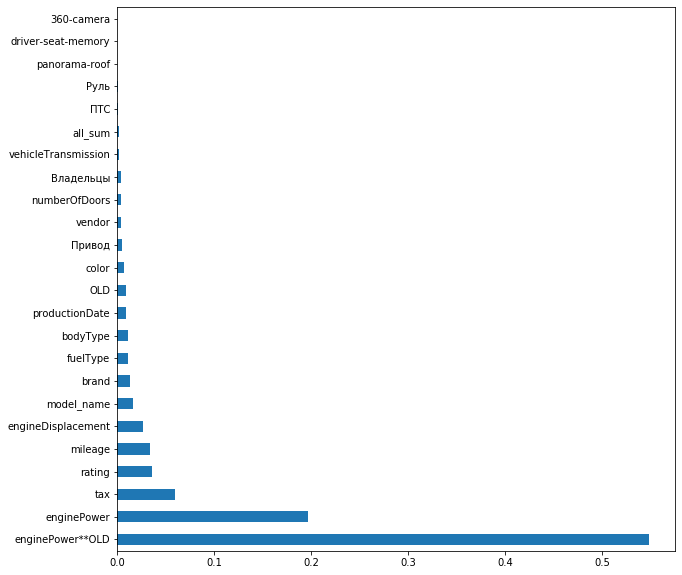

In [77]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,rfr.predict(X_train))
mape(np.exp(y_train), np.exp(rfr.predict(X_train)))
print('Валидационая выборка')
# mape(y_valid,rfr.predict(X_valid))
mape(np.exp(y_valid), np.exp(rfr.predict(X_valid)))

# построим визуализацию важности признаков
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(rfr.feature_importances_, index=df_model_2[set(
    df_model_2.columns)-set(['price', 'city'])].columns)
feat_importances.nlargest(30).plot(kind='barh')

In [79]:
# Подбор Гиперпараметров
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 130, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

#rf = RandomForestRegressor(random_state=42)
#rfr_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                n_iter=70, cv=3, verbose=5, random_state=42, n_jobs=-1)
#rfr_search.fit(X_train, y_train)

#rfr_search.best_params_

#{'n_estimators': 2000,
 #'min_samples_split': 5,
 #'min_samples_leaf': 1,
 #'max_features': 'sqrt',
 #'max_depth': 82,
 #'bootstrap': True}

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 69.3min finished


{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 82,
 'bootstrap': True}

Обучающая выборка
MAPE: 9.28326211862379
Валидационая выборка
MAPE: 16.13011548321735


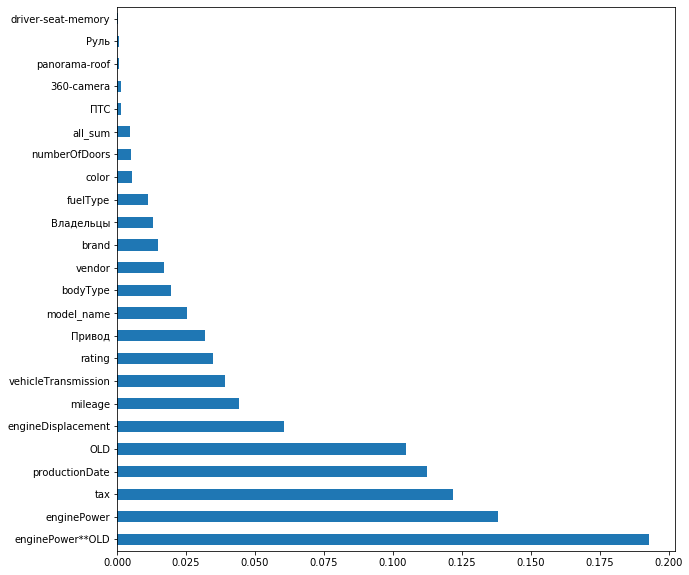

In [91]:
#  с гиперпараметрами
rfr_h = RandomForestRegressor(n_estimators=2000, min_samples_split=5, min_samples_leaf=1,
                              max_features='sqrt', max_depth=82, bootstrap=True, random_state=42, n_jobs=-1)
rfr_h.fit(X_train, y_train)

print('Обучающая выборка')
mape(np.exp(y_train), np.exp(rfr_h.predict(X_train)))
print('Валидационая выборка')
mape(np.exp(y_valid), np.exp(rfr_h.predict(X_valid)))

# построим визуализацию важности признаков
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(rfr_h.feature_importances_, index=df_model_2[set(
    df_model_2.columns)-set(['price', 'city'])].columns)
feat_importances.nlargest(30).plot(kind='barh')

#### Градиентный бустинг с подбором гиперпараметров

In [78]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,gb.predict(X_train))
mape(np.exp(y_train), np.exp(gb.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,gb.predict(X_valid))
mape(np.exp(y_train), np.exp(gb.predict(X_train)))

Обучающая выборка
MAPE: 21.563674675861254
Валидационая выборка
MAPE: 21.563674675861254


In [79]:
# Подбор Гиперпараметров
random_grid_1 = dict()
random_grid_1['n_estimators'] = [10, 50, 100, 200, 350, 500, 750]
random_grid_1['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5]
random_grid_1['max_depth'] = [1, 3, 7, 9]
random_grid_1['min_samples_split'] = [2, 5, 10]
random_grid_1['min_samples_leaf'] = [1, 2, 4]

gb_search = RandomizedSearchCV(estimator=gb, param_distributions=random_grid_1,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
gb_search.fit(X_train, y_train)

gb_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 41.4min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 7,
 'learning_rate': 0.1}

In [148]:
# c гиперпараметрами
gb_h = GradientBoostingRegressor(n_estimators=200, min_samples_split=2,
                                 min_samples_leaf=2, max_depth=7, learning_rate=0.1, random_state=42)
gb_h.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,gb_h.predict(X_train))
mape(np.exp(y_train), np.exp(gb_h.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,gb_h.predict(X_valid))
mape(np.exp(y_train), np.exp(gb_h.predict(X_train)))

Обучающая выборка
MAPE: 12.898328336179892
Валидационая выборка
MAPE: 12.898328336179892


#### Xgb бустинг с подбором гиперпараметров

In [82]:
xgboost = XGBRegressor(random_state=42, n_jobs=-1,
                       objective='reg:squarederror')
xgboost.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,xgboost.predict(X_train))
mape(np.exp(y_train), np.exp(xgboost.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,xgboost.predict(X_valid))
mape(np.exp(y_valid), np.exp(xgboost.predict(X_valid)))

Обучающая выборка
MAPE: 14.124929508179202
Валидационая выборка
MAPE: 17.291411188262575


In [80]:
# Подбор Гиперпараметров
random_grid_2 = {'n_estimators': [10, 50, 100, 500, 1000, 2000], 'num_boost_round': [10, 25, 50], 'learning_rate': [
    0.05, 0.08, 0.1, 0.3], 'max_depth': [1, 3, 4, 5], 'subsample': [0.5, 0.9, 1.0], 'colsample_bytree': [0.5, 0.9, 1.0]}
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

xgb_search = RandomizedSearchCV(estimator=xgb, param_distributions=random_grid_2,
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)

xgb_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.3min finished


[11:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'subsample': 0.9,
 'num_boost_round': 25,
 'n_estimators': 2000,
 'max_depth': 5,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5}

In [126]:
#  с гиперпараметрами
xgboost_h = XGBRegressor(subsample=0.9, n_estimators=2000, max_depth=5, learning_rate=0.05, colsample_bytree=0.5, random_state=42, n_jobs=-1,
                       objective='reg:squarederror')
xgboost_h.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,xgboost_h.predict(X_train))
mape(np.exp(y_train), np.exp(xgboost_h.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,xgboost_h.predict(X_valid))
mape(np.exp(y_valid), np.exp(xgboost_h.predict(X_valid)))

Обучающая выборка
MAPE: 12.421656635322321
Валидационая выборка
MAPE: 16.49540756833542


#### Lightgbm бустинг с подбором гиперпараметров

In [ ]:
lbm = LGBMRegressor(random_state=42, n_jobs=-1)
lbm.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,lbm.predict(X_train))
mape(np.exp(y_train), np.exp(lbm.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,lbm.predict(X_valid))
mape(np.exp(y_valid), np.exp(lbm.predict(X_valid)))

In [83]:
# Подбор Гиперпараметров
n_estimators = [10, 50, 100, 300, 500, 1000]
max_depth = [2, 3, 7, 9]
max_depth.append(None)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 0.3]
random_grid_3 = {'n_estimators': n_estimators,
                 'max_depth': max_depth, 'learning_rate': learning_rate}

lb = LGBMRegressor(random_state=42)

lb_search = RandomizedSearchCV(estimator=lb, param_distributions=random_grid_3,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
lb_search.fit(X_train, y_train)

lb_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1}

In [151]:
# с гиперпараметрами
lbm_h = LGBMRegressor(n_estimators=500, max_depth=9,learning_rate=0.1, random_state=42, n_jobs=-1)
lbm_h.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,lbm_h.predict(X_train))
mape(np.exp(y_train), np.exp(lbm_h.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,lbm_h.predict(X_valid))
mape(np.exp(y_valid), np.exp(lbm_h.predict(X_valid)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Обучающая выборка
MAPE: 13.519511674024395
Валидационая выборка
MAPE: 16.286358083696605


#### Экстремальный случайный лес с подбором гиперпараметров

In [124]:
erfr = ExtraTreesRegressor(random_state=42, n_jobs=-1)
erfr.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,erfr.predict(X_train))
mape(np.exp(y_train), np.exp(erfr.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,erfr.predict(X_valid))
mape(np.exp(y_valid), np.exp(erfr.predict(X_valid)))

Обучающая выборка
MAPE: 0.02502936849275831
Валидационая выборка
MAPE: 16.97818644399682


In [82]:
# Подбор Гиперпараметров
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt', X.shape[1]//3]
max_depth = [int(x) for x in np.linspace(10, 260, num=15)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
random_grid_4 = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
                 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

exf = ExtraTreesRegressor(random_state=42)
exf_search = RandomizedSearchCV(estimator=exf, param_distributions=random_grid_4,
                                n_iter=70, cv=3, verbose=2, random_state=42, n_jobs=-1)
exf_search.fit(X_train, y_train)

exf_search.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 48.7min finished


{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 242,
 'bootstrap': True}

In [147]:
# с гиперпараметрами
erfr_h = ExtraTreesRegressor(n_estimators=1400, min_samples_split=5, min_samples_leaf=1,
                             max_features='auto', max_depth=242, bootstrap=True, random_state=42, n_jobs=-1)
erfr_h.fit(X_train, y_train)

print('Обучающая выборка')
# mape(y_train,erfr_h.predict(X_train))
mape(np.exp(y_train), np.exp(erfr_h.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,erfr_h.predict(X_valid))
mape(np.exp(y_valid), np.exp(erfr_h.predict(X_valid)))

Обучающая выборка
MAPE: 8.715700812294603
Валидационая выборка
MAPE: 16.12449943343178


#### стекинг

In [144]:
# из лучших моделек (с гиперпараметрами взять не могу, компьютер не может)
estimators = [
    ('rfr_h', RandomForestRegressor(random_state=42)),
    ('erfr_h', ExtraTreesRegressor(random_state=42)),
    ('gb_h', GradientBoostingRegressor(n_estimators=200, min_samples_split=2,min_samples_leaf=2, max_depth=7, learning_rate=0.1, random_state=42))]
meta_model=LinearRegression()

In [149]:
st=StackingRegressor(estimators=estimators,final_estimator=meta_model,cv=5, n_jobs=-1,verbose=3)
st.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rfr_h',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     

In [150]:
print('Обучающая выборка')
# mape(y_train,erfr_h.predict(X_train))
mape(np.exp(y_train), np.exp(st.predict(X_train)))

print('Валидационая выборка')
# mape(y_valid,erfr_h.predict(X_valid))
mape(np.exp(y_valid), np.exp(st.predict(X_valid)))

Обучающая выборка
MAPE: 6.307395264332436
Валидационая выборка
MAPE: 15.962384591951388


## Выводы
0. итог на **кэгл к несчастью 68%**. Оказалось, что модель работает хорошо, только с теми брендами, которые были в тестовом сете (как показала проверка). Таким образом идея с добавлением как можно больше количества брендов авто себя не оправдала. Увы. Поскольку переписать все заново и качественно нереально, придется оставить как есть. Либо в ноутбуке есть серьезный просчет, который я пока не вижу. Остальные "более позитивные выводы": 
1. Бэггинг и бустинг работает. Гораздо лучше чем "одно дерево"
2. Стэкинг также работает
3. С помощью подбора гиперпараметров мы смогли уменьшить переобучение модели
4. Однако модель еще не близка к идеалу, идет переобучение, что нужно лечить большим набором данных, новыми признаками, кросс-валидацией
5. на текущий момент выбор сделан на стекинге (интересно было бы проверить, как он справится с моделями с нормально настроенными гиперпараметрами)
6. Ну и самый важный вывод - лезть на кэггл не в самом конце, а хотя бы в середине, чтобы понимать, в какую сторону дальше идти
7. Больше всего времени занял парсинг